In [22]:
from models import OllamaLLM , OllamaEmbedding, EmbSerialVectorClassifier
from TableEmbedder import EmbSerial

import pandas as pd
from typing import Dict, Tuple

def parse_excel_invoice(file_path: str) -> Tuple[Dict, pd.DataFrame]:
    """
    Парсит XLSX файл, разделенный пустой строкой, на словарь метаданных 
    и pandas DataFrame с табличными данными.

    Args:
        file_path: Путь к файлу .xlsx.

    Returns:
        Кортеж, содержащий:
        - Словарь с метаданными (ключ-значение).
        - Pandas DataFrame с данными из основной таблицы.
    """
    try:
        # 1. Читаем весь лист как единую таблицу без заголовка
        df_full = pd.read_excel(file_path, header=None, engine='openpyxl')
    except FileNotFoundError:
        raise FileNotFoundError(f"Файл не найден по пути: {file_path}")
    except Exception as e:
        raise Exception(f"Ошибка при чтении Excel файла: {e}")

    # 2. Находим индекс первой полностью пустой строки (разделителя)
    # Пустая строка будет состоять из значений NaN (Not a Number)
    blank_row_indices = df_full[df_full.isnull().all(axis=1)].index
    if not blank_row_indices.any():
        raise ValueError("Не найдена пустая строка-разделитель в файле.")
    
    separator_index = blank_row_indices[0]

    # 3. Извлекаем блок метаданных (все строки до разделителя)
    df_meta = df_full.iloc[:separator_index]
    
    # 4. Преобразуем метаданные в словарь
    # Используем первую колонку как ключи, вторую — как значения
    # .dropna() удаляет строки, где может быть пустой ключ (например, первая строка "Поле | Значение")
    metadata_dict = df_meta.dropna(subset=[0, 1]).set_index(0)[1].to_dict()

    # 5. Извлекаем блок основной таблицы (все строки после разделителя)
    # Проверяем, есть ли данные после разделителя
    if separator_index + 1 >= len(df_full):
         raise ValueError("Данные таблицы не найдены после строки-разделителя.")
    
    df_table = df_full.iloc[separator_index + 1:].copy()

    # 6. Устанавливаем первую строку как заголовок таблицы
    df_table.columns = df_table.iloc[0]
    
    # 7. Удаляем использованную строку заголовка и сбрасываем индекс
    df_table = df_table.iloc[1:].reset_index(drop=True)
    
    # Очищаем имя индекса колонок, которое могло унаследоваться
    df_table.columns.name = None

    return metadata_dict, df_table


import matplotlib.pyplot as plt
import seaborn as sns
from typing import List
import numpy as np

def plot_cross_table_heatmap(
    emb_list_a: List[EmbSerial], 
    emb_list_b: List[EmbSerial], 
    table_a_name: str = "Таблица A", 
    table_b_name: str = "Таблица B"
):
    """
    Строит heatmap косинусных расстояний между столбцами двух разных таблиц.

    Args:
        emb_list_a (List[EmbSerial]): Список эмбеддингов для первой таблицы (будут по оси Y).
        emb_list_b (List[EmbSerial]): Список эмбеддингов для второй таблицы (будут по оси X).
        table_a_name (str): Название первой таблицы для подписи оси Y.
        table_b_name (str): Название второй таблицы для подписи оси X.
    """
    # Получаем размеры для прямоугольной матрицы
    rows_count = len(emb_list_a)
    cols_count = len(emb_list_b)
    
    # Проверка, что списки не пусты
    if rows_count == 0 or cols_count == 0:
        print("Для построения heatmap оба списка эмбеддингов должны быть не пустыми.")
        return

    # Извлекаем имена для подписей осей
    y_labels = [obj.name for obj in emb_list_a]
    x_labels = [obj.name for obj in emb_list_b]
    
    # Инициализируем прямоугольную матрицу расстояний
    distance_matrix = np.zeros((rows_count, cols_count))
    
    # Заполняем матрицу, вычисляя попарные расстояния между элементами разных списков
    for i in range(rows_count):
        for j in range(cols_count):
            # Вычисляем расстояние между i-м элементом из списка A и j-м из списка B
            distance = emb_list_a[i] - emb_list_b[j]
            distance_matrix[i, j] = distance
            
    # Визуализация
    plt.figure(figsize=(max(8, cols_count * 1.5), max(6, rows_count * 1.2)))
    
    sns.heatmap(
        distance_matrix,
        xticklabels=x_labels,
        yticklabels=y_labels,
        annot=True,
        cmap='viridis_r',
        fmt=".2f"
    )
    
    plt.title(f"Матрица схожести столбцов: '{table_a_name}' vs '{table_b_name}'", fontsize=16)
    plt.xlabel(table_b_name, fontsize=12, fontweight='bold')
    plt.ylabel(table_a_name, fontsize=12, fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    
    plt.show()

import requests
import json
def cross_encoder(text1: str, text2: str):
    api_url = "http://100.74.62.22:8000/score"
    payload = {
        "query": text1,
        "document": text2
    }
    response = requests.post(api_url, data=json.dumps(payload))
    result = response.json()
    return result['score']

def plot_cross_table_heatmap_cross_encoder(
    emb_list_a: List[EmbSerial], 
    emb_list_b: List[EmbSerial], 
    table_a_name: str = "Таблица A", 
    table_b_name: str = "Таблица B"
):
    """
    Строит heatmap косинусных расстояний между столбцами двух разных таблиц.

    Args:
        emb_list_a (List[EmbSerial]): Список эмбеддингов для первой таблицы (будут по оси Y).
        emb_list_b (List[EmbSerial]): Список эмбеддингов для второй таблицы (будут по оси X).
        table_a_name (str): Название первой таблицы для подписи оси Y.
        table_b_name (str): Название второй таблицы для подписи оси X.
    """
    # Получаем размеры для прямоугольной матрицы
    rows_count = len(emb_list_a)
    cols_count = len(emb_list_b)
    
    # Проверка, что списки не пусты
    if rows_count == 0 or cols_count == 0:
        print("Для построения heatmap оба списка эмбеддингов должны быть не пустыми.")
        return

    # Извлекаем имена для подписей осей
    y_labels = [obj.name for obj in emb_list_a]
    x_labels = [obj.name for obj in emb_list_b]
    
    # Инициализируем прямоугольную матрицу расстояний
    distance_matrix = np.zeros((rows_count, cols_count))
    
    # Заполняем матрицу, вычисляя попарные расстояния между элементами разных списков
    for i in range(rows_count):
        for j in range(cols_count):
            # Вычисляем расстояние между i-м элементом из списка A и j-м из списка B
            distance = cross_encoder(emb_list_a[i].description, emb_list_b[j].description)
            distance_matrix[i, j] = distance
            
    # Визуализация
    plt.figure(figsize=(max(8, cols_count * 1.5), max(6, rows_count * 1.2)))
    
    sns.heatmap(
        distance_matrix,
        xticklabels=x_labels,
        yticklabels=y_labels,
        annot=True,
        cmap='viridis_r',
        fmt=".2f"
    )
    
    plt.title(f"Матрица схожести столбцов: '{table_a_name}' vs '{table_b_name}'", fontsize=16)
    plt.xlabel(table_b_name, fontsize=12, fontweight='bold')
    plt.ylabel(table_a_name, fontsize=12, fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    
    plt.show()

metadata1, dataframe1 = parse_excel_invoice(r"c:\Work\table_formatter\generated_invoices\invoice_20250916_115137_968355.xlsx")
metadata2, dataframe2 = parse_excel_invoice(r"C:\Work\table_formatter\generated_invoices\invoice_20250916_115020_659573.xlsx")

In [4]:
metadata, dataframe = parse_excel_invoice(r"C:\Work\table_formatter\generated_invoices\invoice_20250916_115137_968355.xlsx")

In [5]:
metadata

{'Поле': 'Значение',
 'Контракт': 'КН-2023/12-005',
 'ИНН/КПП Покупателя': '7707082493/7707082493',
 'Плательщик': 'ООО «СтройМонтажГаз»',
 'Продавец': 'ООО «Селиверстова, Шашкова и Костина»',
 'Счет-фактура №': 'СФ-2023/12-001',
 'от': '2023-12-15',
 'ИНН/КПП Поставщика': '7811189816/7811189816'}

In [6]:
dataframe

,Код товара,Цена по прайсу,Страна,Номер ГТД,"Дисконт, %",Поз.,Число коробок,Отпускная цена,Категория,Номенклатура,Сумма,Всего с НДС,Ед.,Ед. в месте,Сумма НДС,НДС,Код поставщика
0,4601123456789,41559.4,Китай,6303900000,10,12,33,37403.46,Средства для мытья,"Гель для мытья посуды 'Блеск' концентрат, 5л",62950023.18,75540027.82,упак.,51,12590004.64,20,SUP-CHN-007
1,4567890123456,24796.16,Китай,6902100000,0,12,8,24796.16,Упаковка,"Пакеты для мусора, 60 л, черный, 30 шт в уп.",16663019.52,19995623.42,уп.,84,3332603.9,20,SUPP-2023-005
2,1234567890,65978.35,Китай,1234567890123,0,1,44,65978.35,Бытовая химия,"Средство для мытья посуды концентрированное, 5л",26127426.6,28740169.26,упак.,9,2612742.66,10,SUP007
3,12345678,50756.59,Китай,98989898,25,1,40,38067.44,Упаковка,Мешки полипропиленовые 1200х900х150 мкм,53294419.5,58623861.45,шт.,35,5329441.95,10,P123
4,1234567890,23662.44,Китай,1234567890123,0,1,2,23662.44,Упаковка,"Пакеты мусорные черные, 40x50 см",1325096.64,1590115.97,упак.,28,265019.33,20,ABC123
5,2345678,1803.01,Китай,6902900000,20,12,8,1442.41,Инструмент,Набор отверток с напайками 12 шт.,773130.69,927756.83,упак.,67,154626.14,20,SUP-789
6,1234567890,5851.11,Китай,9999999999,10,1,30,5266,Упаковка,"Пакеты полипропиленовые с ручками, 50 шт/упак.",13270317.48,15924380.98,упак.,84,2654063.5,20,SUP007
7,7439101011,47113.12,Китай,6306390000,10,12,34,42401.81,Бытовая химия,"Средство для мытья стекол 'Кристалл', 5л",67758089.18,81309707.02,упак.,47,13551617.84,20,SUP-00842
8,ХТ-00457,51596.68,Китай,9406900000,10,12,29,46437.01,Упаковка,"Пакеты полипропиленовые черные 45x60, 100шт.",122547274.67,122547274.67,упак.,91,0,0,ПС-78921
9,8471302000,74755.11,Китай,6303990000,10,12,45,67279.6,Прочие хозяйственные товары,"Салфетки влажные антибактериальные, 10 шт. в уп.",142296351.88,156525987.07,упак.,47,14229635.19,10,SUPP-HW-2023


In [7]:
host = 'http://100.74.62.22:11434' 
llm_name = 'gemma3:12b'
emb_name = "dengcao/Qwen3-Embedding-0.6B:F16"
#emb_name = "embeddinggemma"
embedder = OllamaEmbedding(host = host, model = emb_name)
llm = OllamaLLM(host = host, model=llm_name)

serial1 = EmbSerial(embedder=embedder, llm = llm, name = 'Страна', content = dataframe['Страна'].tolist())
serial2 = EmbSerial(embedder=embedder, llm = llm, name = 'Номенклатура', content = dataframe['Номенклатура'].tolist())
serial3 = EmbSerial(embedder=embedder, llm = llm, name = 'Всего с НДС', content = dataframe['Всего с НДС'].tolist())
serial4 = EmbSerial(embedder=embedder, llm = llm, name = 'Сумма', content = dataframe['Сумма'].tolist())

Обработка столбца Страна...
Столбец обработан!
Обработка столбца Номенклатура...
Столбец обработан!
Обработка столбца Всего с НДС...
Столбец обработан!
Обработка столбца Сумма...
Столбец обработан!


In [8]:
serial1.description, len(serial1.embedding)

('Страна происхождения товара или место регистрации компании.\n', 1024)

In [9]:
serial2.description, len(serial2.embedding)

('Товары для дома и хозяйственные нужды: моющие средства, пакеты, мешки.\n',
 1024)

In [10]:
serial3.description, len(serial3.embedding)

('Общая сумма платежей, включая налог на добавленную стоимость (НДС).\n', 1024)

In [11]:
serial4.description, len(serial4.embedding)

('Общая стоимость транзакций, платежей или объемов продаж.\n', 1024)

In [12]:
norm = serial1 - serial2
1 - norm

np.float64(0.45239964871651583)

In [13]:
Serials = []
for name in dataframe.keys():
    Serials.append(EmbSerial(embedder=embedder, llm = llm, name = name, content = dataframe[name].tolist()))

Обработка столбца Код товара...
Столбец обработан!
Обработка столбца Цена по прайсу...
Столбец обработан!
Обработка столбца Страна...
Столбец обработан!
Обработка столбца Номер ГТД...
Столбец обработан!
Обработка столбца Дисконт, %...
Столбец обработан!
Обработка столбца Поз....
Столбец обработан!
Обработка столбца Число коробок...
Столбец обработан!
Обработка столбца Отпускная цена...
Столбец обработан!
Обработка столбца Категория...
Столбец обработан!
Обработка столбца Номенклатура...
Столбец обработан!
Обработка столбца Сумма...
Столбец обработан!
Обработка столбца Всего с НДС...
Столбец обработан!
Обработка столбца Ед....
Столбец обработан!
Обработка столбца Ед. в месте...
Столбец обработан!
Обработка столбца Сумма НДС...
Столбец обработан!
Обработка столбца НДС...
Столбец обработан!
Обработка столбца Код поставщика...
Столбец обработан!


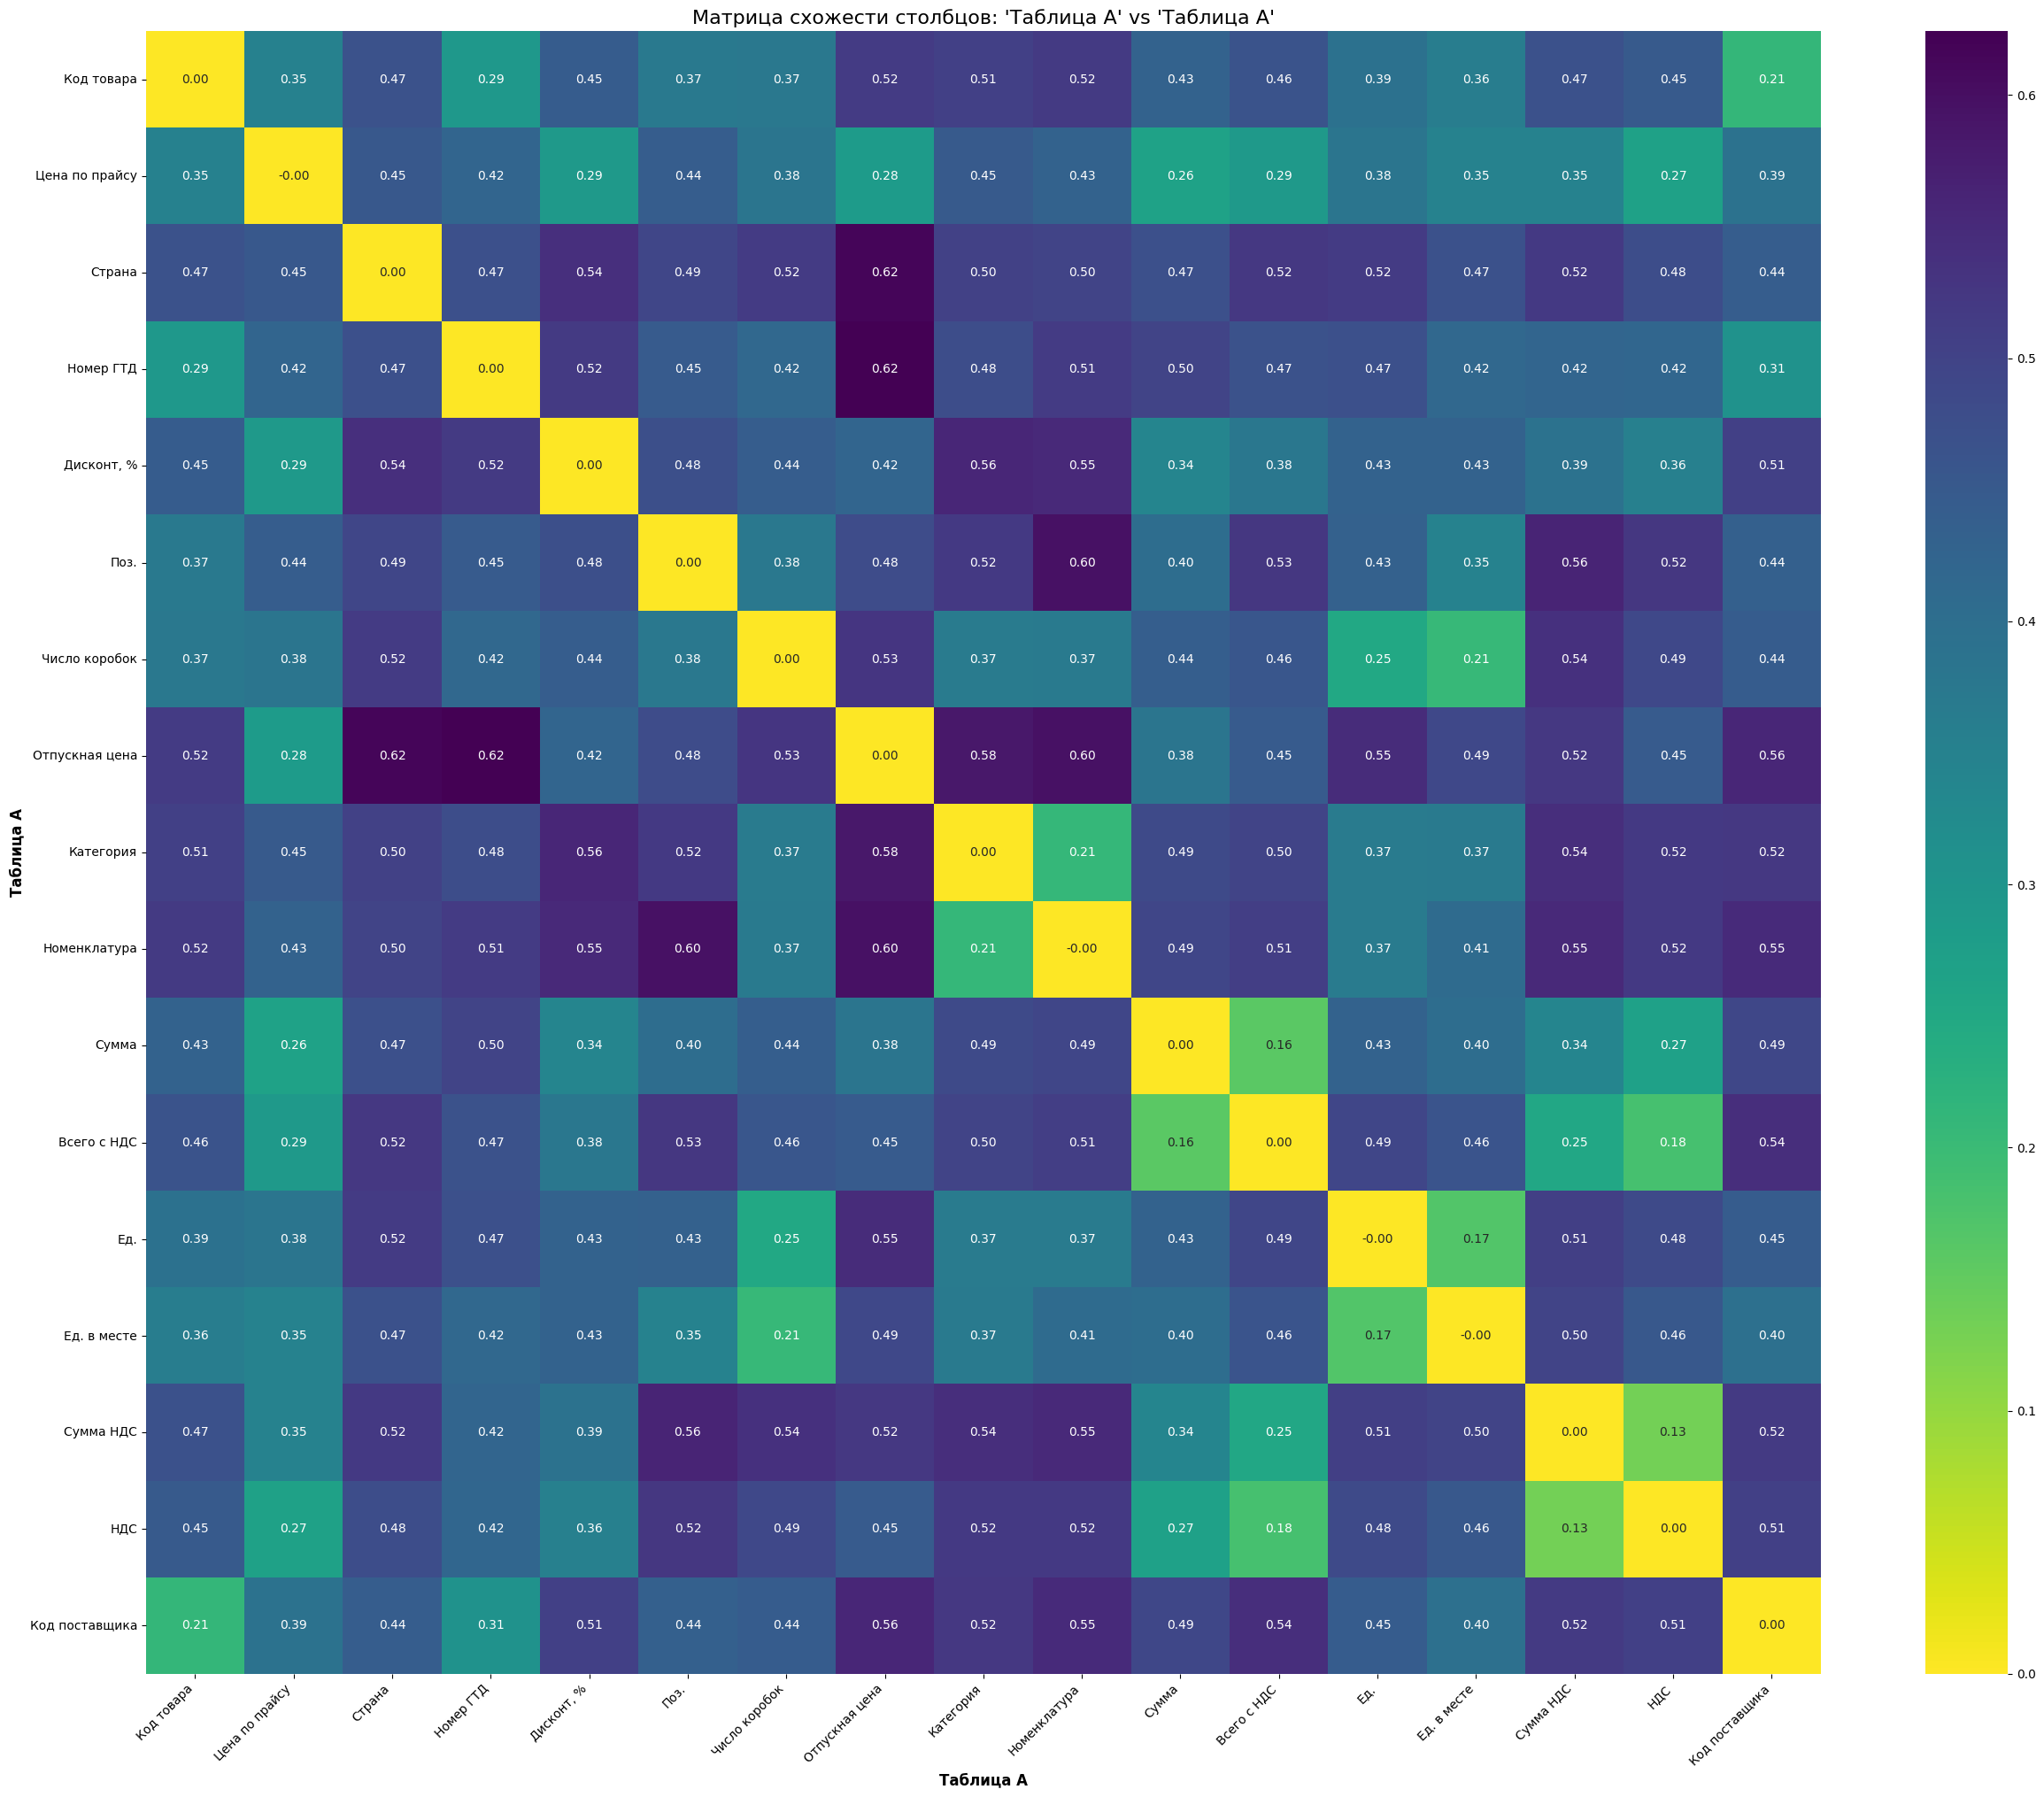

In [14]:
plot_cross_table_heatmap(
    emb_list_a = Serials, 
    emb_list_b = Serials, 
    table_a_name = "Таблица A", 
    table_b_name = "Таблица A"
)

## ЭКСПЕРИМЕНТЫ

In [5]:
metadata1, dataframe1 = parse_excel_invoice(r"c:\Work\table_formatter\generated_invoices\invoice_20250916_115137_968355.xlsx")
metadata2, dataframe2 = parse_excel_invoice(r"C:\Work\table_formatter\generated_invoices\invoice_20250916_115020_659573.xlsx")

In [3]:
metadata1, metadata2

({'Поле': 'Значение',
  'Контракт': 'КН-2023/12-005',
  'ИНН/КПП Покупателя': '7707082493/7707082493',
  'Плательщик': 'ООО «СтройМонтажГаз»',
  'Продавец': 'ООО «Селиверстова, Шашкова и Костина»',
  'Счет-фактура №': 'СФ-2023/12-001',
  'от': '2023-12-15',
  'ИНН/КПП Поставщика': '7811189816/7811189816'},
 {'Поле': 'Значение',
  'Поставщик': 'ФСК Лидер',
  'Счет на оплату №': 'С-2024-07-15-001',
  'от': '15.07.2024',
  'Реквизиты Покупателя': "ООО 'Партнер', 1234567890, 1234567890-78-1234567890",
  'Договор №': 'Д-2023-100',
  'ИНН/КПП Поставщика': '770101123456/7701011234',
  'Покупатель': "ООО 'Партнер'"})

In [4]:
dataframe1

,Код товара,Цена по прайсу,Страна,Номер ГТД,"Дисконт, %",Поз.,Число коробок,Отпускная цена,Категория,Номенклатура,Сумма,Всего с НДС,Ед.,Ед. в месте,Сумма НДС,НДС,Код поставщика
0,4601123456789,41559.4,Китай,6303900000,10,12,33,37403.46,Средства для мытья,"Гель для мытья посуды 'Блеск' концентрат, 5л",62950023.18,75540027.82,упак.,51,12590004.64,20,SUP-CHN-007
1,4567890123456,24796.16,Китай,6902100000,0,12,8,24796.16,Упаковка,"Пакеты для мусора, 60 л, черный, 30 шт в уп.",16663019.52,19995623.42,уп.,84,3332603.9,20,SUPP-2023-005
2,1234567890,65978.35,Китай,1234567890123,0,1,44,65978.35,Бытовая химия,"Средство для мытья посуды концентрированное, 5л",26127426.6,28740169.26,упак.,9,2612742.66,10,SUP007
3,12345678,50756.59,Китай,98989898,25,1,40,38067.44,Упаковка,Мешки полипропиленовые 1200х900х150 мкм,53294419.5,58623861.45,шт.,35,5329441.95,10,P123
4,1234567890,23662.44,Китай,1234567890123,0,1,2,23662.44,Упаковка,"Пакеты мусорные черные, 40x50 см",1325096.64,1590115.97,упак.,28,265019.33,20,ABC123
5,2345678,1803.01,Китай,6902900000,20,12,8,1442.41,Инструмент,Набор отверток с напайками 12 шт.,773130.69,927756.83,упак.,67,154626.14,20,SUP-789
6,1234567890,5851.11,Китай,9999999999,10,1,30,5266,Упаковка,"Пакеты полипропиленовые с ручками, 50 шт/упак.",13270317.48,15924380.98,упак.,84,2654063.5,20,SUP007
7,7439101011,47113.12,Китай,6306390000,10,12,34,42401.81,Бытовая химия,"Средство для мытья стекол 'Кристалл', 5л",67758089.18,81309707.02,упак.,47,13551617.84,20,SUP-00842
8,ХТ-00457,51596.68,Китай,9406900000,10,12,29,46437.01,Упаковка,"Пакеты полипропиленовые черные 45x60, 100шт.",122547274.67,122547274.67,упак.,91,0,0,ПС-78921
9,8471302000,74755.11,Китай,6303990000,10,12,45,67279.6,Прочие хозяйственные товары,"Салфетки влажные антибактериальные, 10 шт. в уп.",142296351.88,156525987.07,упак.,47,14229635.19,10,SUPP-HW-2023


In [5]:
dataframe2

,SKU,Цена по прайсу,Страна происхождения,Номер ГТД,"Дисконт, %",№,Комментарий,Кол-во мест,Категория,Номенклатура,Сумма с НДС,Фасовка,В т.ч. НДС,Ставка НДС,Код поставщика
0,OFM-CH-003,59381.81,Германия,9401210000,5,12,Офисный стул с регулируемой высотой и подлокот...,7,Офисные кресла,Кресло офисное ComfortLine,22745608.5,48,3790934.75,20,SUP-GER-147
1,OFM-ERG-CH-001,18859.67,Италия,4401100000,0,123,"Эргономичное кресло для руководителя, обивка -...",43,Кресла для руководителей,Кресло руководителя ERG-CH,31627666.59,39,0,0,ITMBL-2023-001
2,OF-CH-003,4117.4,Китай,1901909000,0,5,Предназначен для кабинета руководителя.,17,Кресла,"Кресло офисное с подлокотниками, цвет серый",167989.92,2,27998.32,20,SUP-OFF-012
3,MF-CH-0042,31602.37,Китай,3924100000,0,12,"Для кабинета руководителя, комплектация 'Премиум'",30,Кресла,"Кресло офисное с подлокотниками, экокожа 'Атлант'",19340650.44,17,3223441.74,20,SUP-OFFICE-087
4,OF-CH-0047,38137.09,Германия,9401210000,0,12,"Кресло для руководителя, экокожа, цвет серый",8,Кресла для руководителей,"Кресло руководителя 'Executive' (экокожа, серый)",27855330.54,83,2532302.78,10,SUP-GER-007
5,FM-CH-0042,62118.38,Китай,9401909000,0,12,"Кресло офисное, с подлокотниками, цвет серый.",32,Кресла,Кресло офисное ErgoFlex Pro,71560373.76,30,11926728.96,20,SUP-OFFICE-1488
6,MF-CH-007,35284.82,Китай,4304100000,10,12,"Офисный стул с подлокотниками, черного цвета. ...",35,Офисные кресла,Кресло офисное Comfort Pro,17338960.55,13,2889826.76,20,SUP-OFFICE-042
7,MF-CH-001,9984.51,Китай,4802910000,0,123,"Для офиса, в разобранном виде",10,Кресла для персонала,"Кресло офисное с подлокотниками, черное, ткань",6110520.12,51,1018420.02,20,SUP-OFFICE-007
8,MF-CH-007,36801.96,Китай,1901909000,0,123,"Офисный кресло, эргономичная спинка, ткань 'Пр...",28,Кресла офисные,Кресло офисное 'Executive',32150192.26,26,5358365.38,20,SUP-OFFICE-2023
9,OFM-CH-003,73484.42,Китай,3918100000,0,12,"Офисный стул, кресло для руководителя, с подло...",7,Офисные кресла,Кресло для руководителя 'Executive Black',29628918.14,48,4938153.02,20,SUP-OFM-005


In [6]:
dataframe1.keys(), dataframe2.keys(), metadata1, metadata2

(Index(['Код товара', 'Цена по прайсу', 'Страна', 'Номер ГТД', 'Дисконт, %',
        'Поз.', 'Число коробок', 'Отпускная цена', 'Категория', 'Номенклатура',
        'Сумма', 'Всего с НДС', 'Ед.', 'Ед. в месте', 'Сумма НДС', 'НДС',
        'Код поставщика'],
       dtype='object'),
 Index(['SKU', 'Цена по прайсу', 'Страна происхождения', 'Номер ГТД',
        'Дисконт, %', '№', 'Комментарий', 'Кол-во мест', 'Категория',
        'Номенклатура', 'Сумма с НДС', 'Фасовка', 'В т.ч. НДС', 'Ставка НДС',
        'Код поставщика'],
       dtype='object'),
 {'Поле': 'Значение',
  'Контракт': 'КН-2023/12-005',
  'ИНН/КПП Покупателя': '7707082493/7707082493',
  'Плательщик': 'ООО «СтройМонтажГаз»',
  'Продавец': 'ООО «Селиверстова, Шашкова и Костина»',
  'Счет-фактура №': 'СФ-2023/12-001',
  'от': '2023-12-15',
  'ИНН/КПП Поставщика': '7811189816/7811189816'},
 {'Поле': 'Значение',
  'Поставщик': 'ФСК Лидер',
  'Счет на оплату №': 'С-2024-07-15-001',
  'от': '15.07.2024',
  'Реквизиты Покупателя': "

In [7]:
dataframe2['Кол-во мест']

0      7
1     43
2     17
3     30
4      8
5     32
6     35
7     10
8     28
9      7
10    22
11    13
12    20
13    29
Name: Кол-во мест, dtype: object

## Gemma3:27b + Qwen-Embedding

Обработка столбца Код товара...
Столбец обработан!
Обработка столбца Категория...
Столбец обработан!
Обработка столбца Страна...
Столбец обработан!
Обработка столбца Номенклатура...
Столбец обработан!
Обработка столбца Сумма...
Столбец обработан!
Обработка столбца Число коробок...
Столбец обработан!
Обработка столбца Ед. в месте...
Столбец обработан!
Обработка столбца Плательщик...
Столбец обработан!
Обработка столбца Продавец...
Столбец обработан!
Обработка столбца Счет-фактура №...
Столбец обработан!
Обработка столбца SKU...
Столбец обработан!
Обработка столбца Категория...
Столбец обработан!
Обработка столбца Страна происхождения...
Столбец обработан!
Обработка столбца Номенклатура...
Столбец обработан!
Обработка столбца Цена по прайсу...
Столбец обработан!
Обработка столбца Кол-во мест...
Столбец обработан!
Обработка столбца Фасовка...
Столбец обработан!
Обработка столбца Покупатель...
Столбец обработан!
Обработка столбца Поставщик...
Столбец обработан!
Обработка столбца Счет на оп

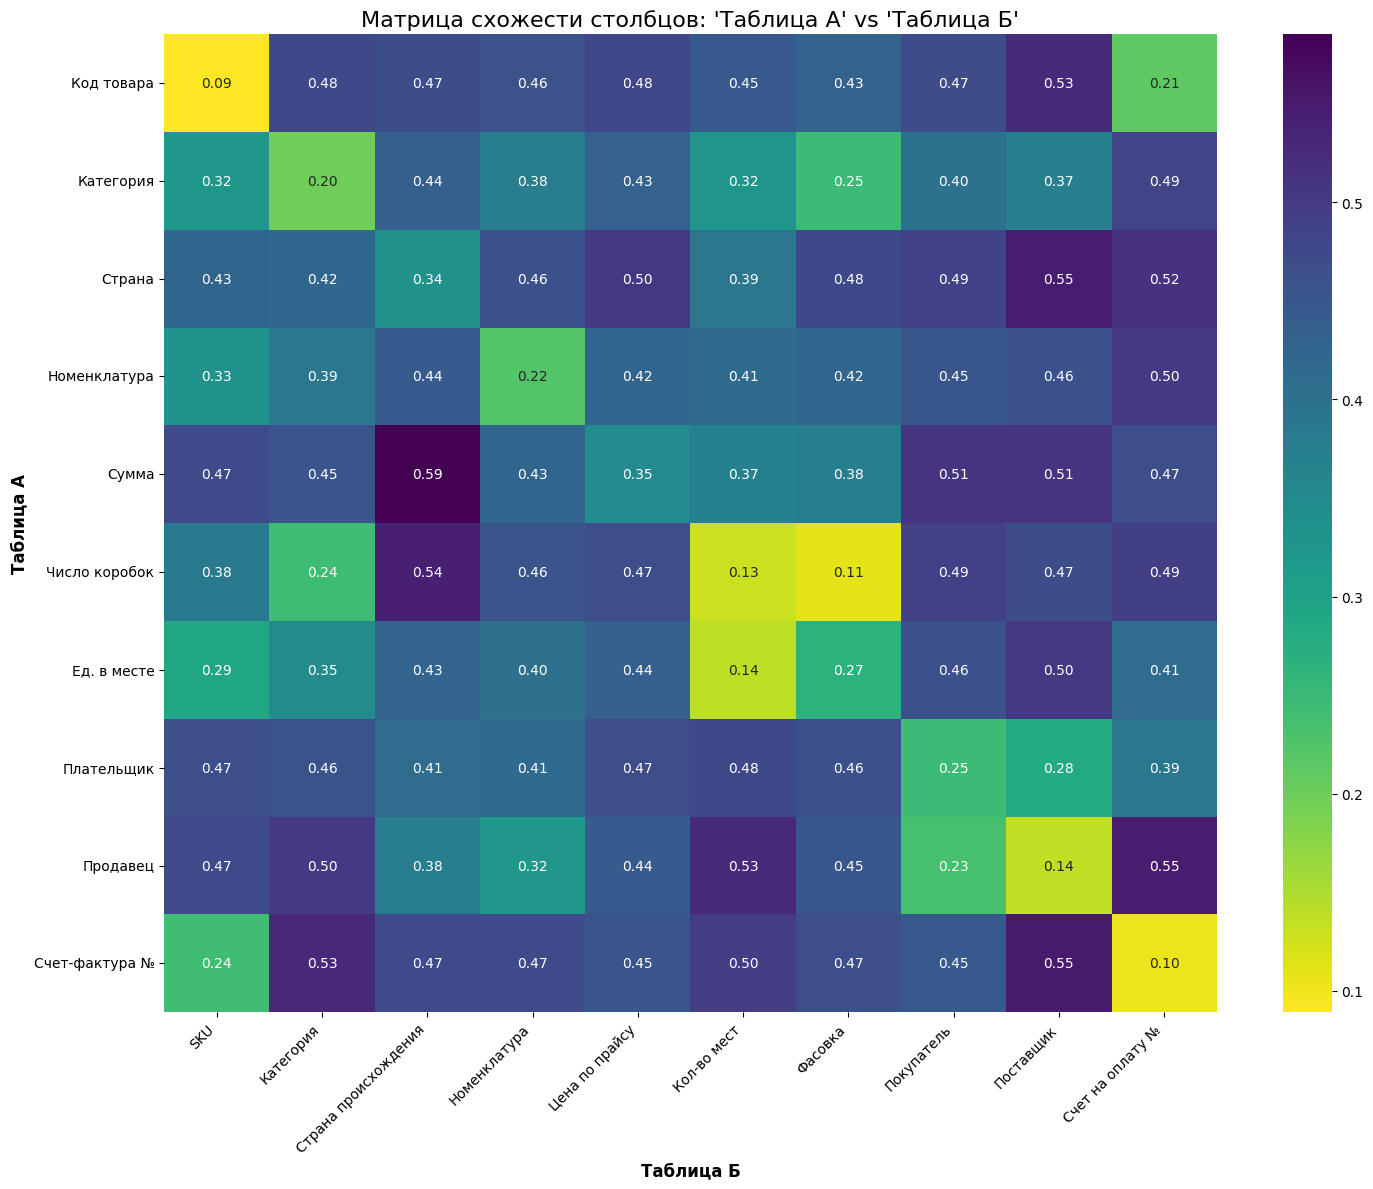

In [8]:
host = 'http://100.74.62.22:11434' 
llm_name = 'gemma3:27b'
emb_name = "dengcao/Qwen3-Embedding-0.6B:F16"
#emb_name = "embeddinggemma"
embedder = OllamaEmbedding(host = host, model = emb_name)
llm = OllamaLLM(host = host, model=llm_name)

#Артикул Страна Номенклатура СуммарнаяЦена Количество Покупатель Продавец 

# Таблица А
Serials1 = []
keys1 = ['Код товара','Категория', 'Страна','Номенклатура', 'Сумма', 'Число коробок', 'Ед. в месте']
for key in keys1:
    Serials1.append(EmbSerial(embedder=embedder, llm=llm, name = key, content = dataframe1[key].tolist()))

mets1 = ['Плательщик', 'Продавец', 'Счет-фактура №']
for met in mets1:
    Serials1.append(EmbSerial(embedder=embedder, llm=llm, name = met, content = [metadata1[met]]))

# Таблица Б
Serials2 = []
keys2 = ['SKU', 'Категория', 'Страна происхождения', 'Номенклатура', 'Цена по прайсу', 'Кол-во мест', 'Фасовка']
for key in keys2:
    Serials2.append(EmbSerial(embedder=embedder, llm=llm, name = key, content = dataframe2[key].tolist()))

mets2 = ['Покупатель', 'Поставщик', 'Счет на оплату №']
for met in mets2:
    Serials2.append(EmbSerial(embedder=embedder, llm=llm, name = met, content = [metadata2[met]]))

plot_cross_table_heatmap(
    emb_list_a = Serials1, 
    emb_list_b = Serials2, 
    table_a_name = "Таблица A", 
    table_b_name = "Таблица Б"
)

In [9]:
for Serial in Serials1:
    print(Serial.description)
print('---------')
for Serial in Serials2:
    print(Serial.description)

Уникальный идентификатор товара. Может использоваться для внутреннего учета, поиска и сопоставления товаров в системе.

Группа, к которой относится товар или элемент данных.

Географическое местоположение или регион, связанный с данными в строке.

Наименование товара или услуги, подробное описание позиции в ассортименте.

Общая денежная величина, выраженная в числовом формате. Может представлять собой стоимость, оплату, прибыль, начисление или другую финансовую метрику.

Количество единиц в группе или партии.

Количество или идентификатор единиц в указанном месте.

Наименование юридического или физического лица, производящего платеж или являющегося источником финансовых средств.

Наименование юридического или физического лица, осуществляющего продажу товаров или услуг.

Уникальный идентификатор документа, подтверждающего факт совершения сделки и содержащего данные о товарах, услугах, ценах и суммах налогов.

---------
Уникальный идентификатор товара или позиции.

Группа, тип или класси

## Gemma3:27b + embeddinggemma

Обработка столбца Код товара...
Столбец обработан!
Обработка столбца Категория...
Столбец обработан!
Обработка столбца Страна...
Столбец обработан!
Обработка столбца Номенклатура...
Столбец обработан!
Обработка столбца Сумма...
Столбец обработан!
Обработка столбца Число коробок...
Столбец обработан!
Обработка столбца Ед. в месте...
Столбец обработан!
Обработка столбца Плательщик...
Столбец обработан!
Обработка столбца Продавец...
Столбец обработан!
Обработка столбца Счет-фактура №...
Столбец обработан!
Обработка столбца SKU...
Столбец обработан!
Обработка столбца Категория...
Столбец обработан!
Обработка столбца Страна происхождения...
Столбец обработан!
Обработка столбца Номенклатура...
Столбец обработан!
Обработка столбца Цена по прайсу...
Столбец обработан!
Обработка столбца Кол-во мест...
Столбец обработан!
Обработка столбца Фасовка...
Столбец обработан!
Обработка столбца Покупатель...
Столбец обработан!
Обработка столбца Поставщик...
Столбец обработан!
Обработка столбца Счет на оп

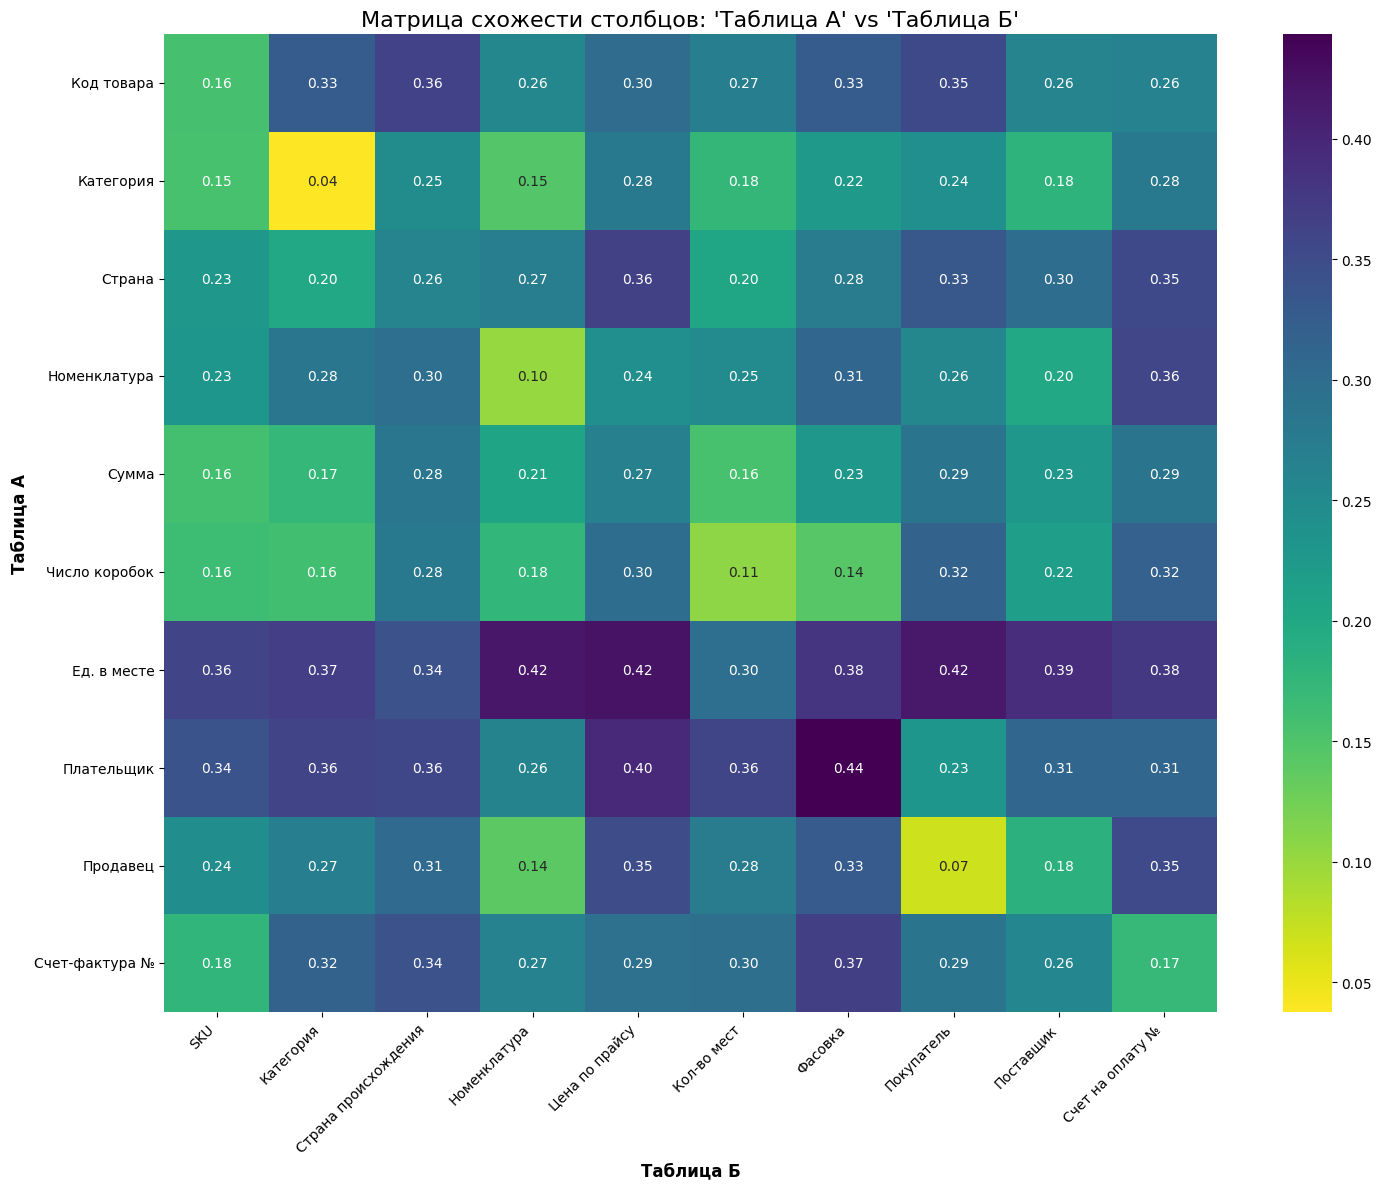

In [10]:
host = 'http://100.74.62.22:11434' 
llm_name = 'gemma3:27b'
#emb_name = "dengcao/Qwen3-Embedding-0.6B:F16"
emb_name = "embeddinggemma"
embedder = OllamaEmbedding(host = host, model = emb_name)
llm = OllamaLLM(host = host, model=llm_name)

#Артикул Страна Номенклатура СуммарнаяЦена Количество Покупатель Продавец 

# Таблица А
Serials1 = []
keys1 = ['Код товара','Категория', 'Страна','Номенклатура', 'Сумма', 'Число коробок', 'Ед. в месте']
for key in keys1:
    Serials1.append(EmbSerial(embedder=embedder, llm=llm, name = key, content = dataframe1[key].tolist()))

mets1 = ['Плательщик', 'Продавец', 'Счет-фактура №']
for met in mets1:
    Serials1.append(EmbSerial(embedder=embedder, llm=llm, name = met, content = [metadata1[met]]))

# Таблица Б
Serials2 = []
keys2 = ['SKU', 'Категория', 'Страна происхождения', 'Номенклатура', 'Цена по прайсу', 'Кол-во мест', 'Фасовка']
for key in keys2:
    Serials2.append(EmbSerial(embedder=embedder, llm=llm, name = key, content = dataframe2[key].tolist()))

mets2 = ['Покупатель', 'Поставщик', 'Счет на оплату №']
for met in mets2:
    Serials2.append(EmbSerial(embedder=embedder, llm=llm, name = met, content = [metadata2[met]]))

plot_cross_table_heatmap(
    emb_list_a = Serials1, 
    emb_list_b = Serials2, 
    table_a_name = "Таблица A", 
    table_b_name = "Таблица Б"
)

In [11]:
for Serial in Serials1:
    print(Serial.description)
print('---------')
for Serial in Serials2:
    print(Serial.description)

Уникальный идентификатор товара. Может использоваться для внутренних нужд системы или для связи с другими системами.

Группа, к которой относится товар или элемент данных.

Географическое или политическое местоположение, к которому относится запись.

Наименование товара или услуги, подробное описание позиций в ассортименте.

Общая числовая величина, представляющая количественную характеристику.

Количество отдельных элементов или контейнеров.

Количественный показатель, связанный с местоположением или объектом. Может представлять собой номер, индекс, код или другую числовую характеристику, идентифицирующую место или объект.

Наименование юридического или физического лица, производящего платеж или выступающего источником финансирования.

Наименование организации или физического лица, осуществляющего продажу товаров или услуг.

Уникальный идентификатор документа, подтверждающего факт совершения сделки и содержащего информацию о товарах, услугах, ценах и суммах.

---------
Уникальный иден

## gpt-oss:20b  + embeddinggemma

Обработка столбца Код товара...
Столбец обработан!
Обработка столбца Категория...
Столбец обработан!
Обработка столбца Страна...
Столбец обработан!
Обработка столбца Номенклатура...
Столбец обработан!
Обработка столбца Сумма...
Столбец обработан!
Обработка столбца Число коробок...
Столбец обработан!
Обработка столбца Ед. в месте...
Столбец обработан!
Обработка столбца Плательщик...
Столбец обработан!
Обработка столбца Продавец...
Столбец обработан!
Обработка столбца Счет-фактура №...
Столбец обработан!
Обработка столбца SKU...
Столбец обработан!
Обработка столбца Категория...
Столбец обработан!
Обработка столбца Страна происхождения...
Столбец обработан!
Обработка столбца Номенклатура...
Столбец обработан!
Обработка столбца Цена по прайсу...
Столбец обработан!
Обработка столбца Кол-во мест...
Столбец обработан!
Обработка столбца Фасовка...
Столбец обработан!
Обработка столбца Покупатель...
Столбец обработан!
Обработка столбца Поставщик...
Столбец обработан!
Обработка столбца Счет на оп

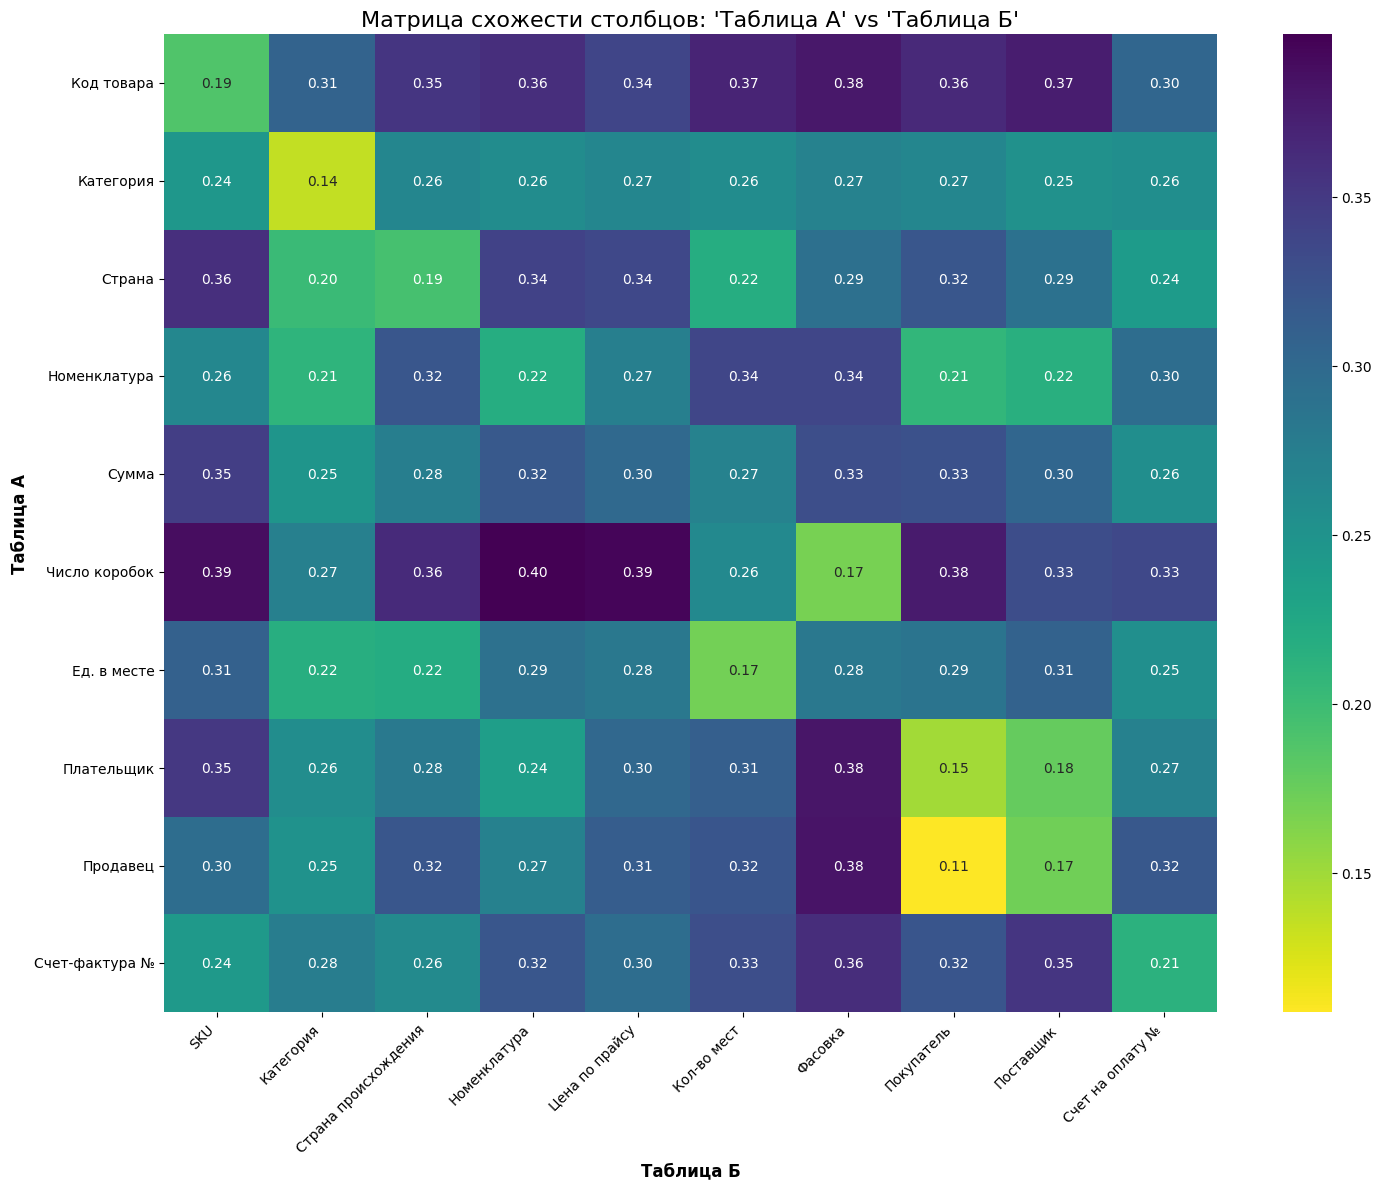

In [14]:
host = 'http://100.74.62.22:11434' 
llm_name = 'gpt-oss:20b'
#emb_name = "dengcao/Qwen3-Embedding-0.6B:F16"
emb_name = "embeddinggemma"
embedder = OllamaEmbedding(host = host, model = emb_name)
llm = OllamaLLM(host = host, model=llm_name)

#Артикул Страна Номенклатура СуммарнаяЦена Количество Покупатель Продавец 

# Таблица А
Serials1 = []
keys1 = ['Код товара','Категория', 'Страна','Номенклатура', 'Сумма', 'Число коробок', 'Ед. в месте']
for key in keys1:
    Serials1.append(EmbSerial(embedder=embedder, llm=llm, name = key, content = dataframe1[key].tolist()))

mets1 = ['Плательщик', 'Продавец', 'Счет-фактура №']
for met in mets1:
    Serials1.append(EmbSerial(embedder=embedder, llm=llm, name = met, content = [metadata1[met]]))

# Таблица Б
Serials2 = []
keys2 = ['SKU', 'Категория', 'Страна происхождения', 'Номенклатура', 'Цена по прайсу', 'Кол-во мест', 'Фасовка']
for key in keys2:
    Serials2.append(EmbSerial(embedder=embedder, llm=llm, name = key, content = dataframe2[key].tolist()))

mets2 = ['Покупатель', 'Поставщик', 'Счет на оплату №']
for met in mets2:
    Serials2.append(EmbSerial(embedder=embedder, llm=llm, name = met, content = [metadata2[met]]))

plot_cross_table_heatmap(
    emb_list_a = Serials1, 
    emb_list_b = Serials2, 
    table_a_name = "Таблица A", 
    table_b_name = "Таблица Б"
)

In [15]:
for Serial in Serials1:
    print(Serial.description)
print('---------')
for Serial in Serials2:
    print(Serial.description)

Уникальный числовой код товара, состоящий из 8–13 цифр, используемый для идентификации продукции в системе.
Категория продукта, обозначающая тип товара или область применения.
Страна, обозначающая географическое расположение объекта или события.
Наименование товара, включающее бренд, тип, размер, объем и другие характеристические детали.
Общая численная величина, часто денежная, представляющая сумму или агрегированный показатель.
Количество коробок, используемых для упаковки, хранения или транспортировки товаров.
Количество единиц (объектов, предметов, сотрудников и т.п.) на конкретном месте.
Наименование плательщика (организации или физического лица)
Наименование продавца (организации, индивидуального предпринимателя или физического лица)
Уникальный номер налоговой инвойсы, обычно включающий код, год, месяц и порядковый номер.
---------
Уникальный товарный код (SKU) – алфавитно‑цифровая комбинация, идентифицирующая конкретный продукт в системе учёта и продаж.
Классификация товаров по 

## gpt-oss:20b + Qwen-Embedding

Обработка столбца Код товара...
Столбец обработан!
Обработка столбца Категория...
Столбец обработан!
Обработка столбца Страна...
Столбец обработан!
Обработка столбца Номенклатура...
Столбец обработан!
Обработка столбца Сумма...
Столбец обработан!
Обработка столбца Число коробок...
Столбец обработан!
Обработка столбца Ед. в месте...
Столбец обработан!
Обработка столбца Плательщик...
Столбец обработан!
Обработка столбца Продавец...
Столбец обработан!
Обработка столбца Счет-фактура №...
Столбец обработан!
Обработка столбца SKU...
Столбец обработан!
Обработка столбца Категория...
Столбец обработан!
Обработка столбца Страна происхождения...
Столбец обработан!
Обработка столбца Номенклатура...
Столбец обработан!
Обработка столбца Цена по прайсу...
Столбец обработан!
Обработка столбца Кол-во мест...
Столбец обработан!
Обработка столбца Фасовка...
Столбец обработан!
Обработка столбца Покупатель...
Столбец обработан!
Обработка столбца Поставщик...
Столбец обработан!
Обработка столбца Счет на оп

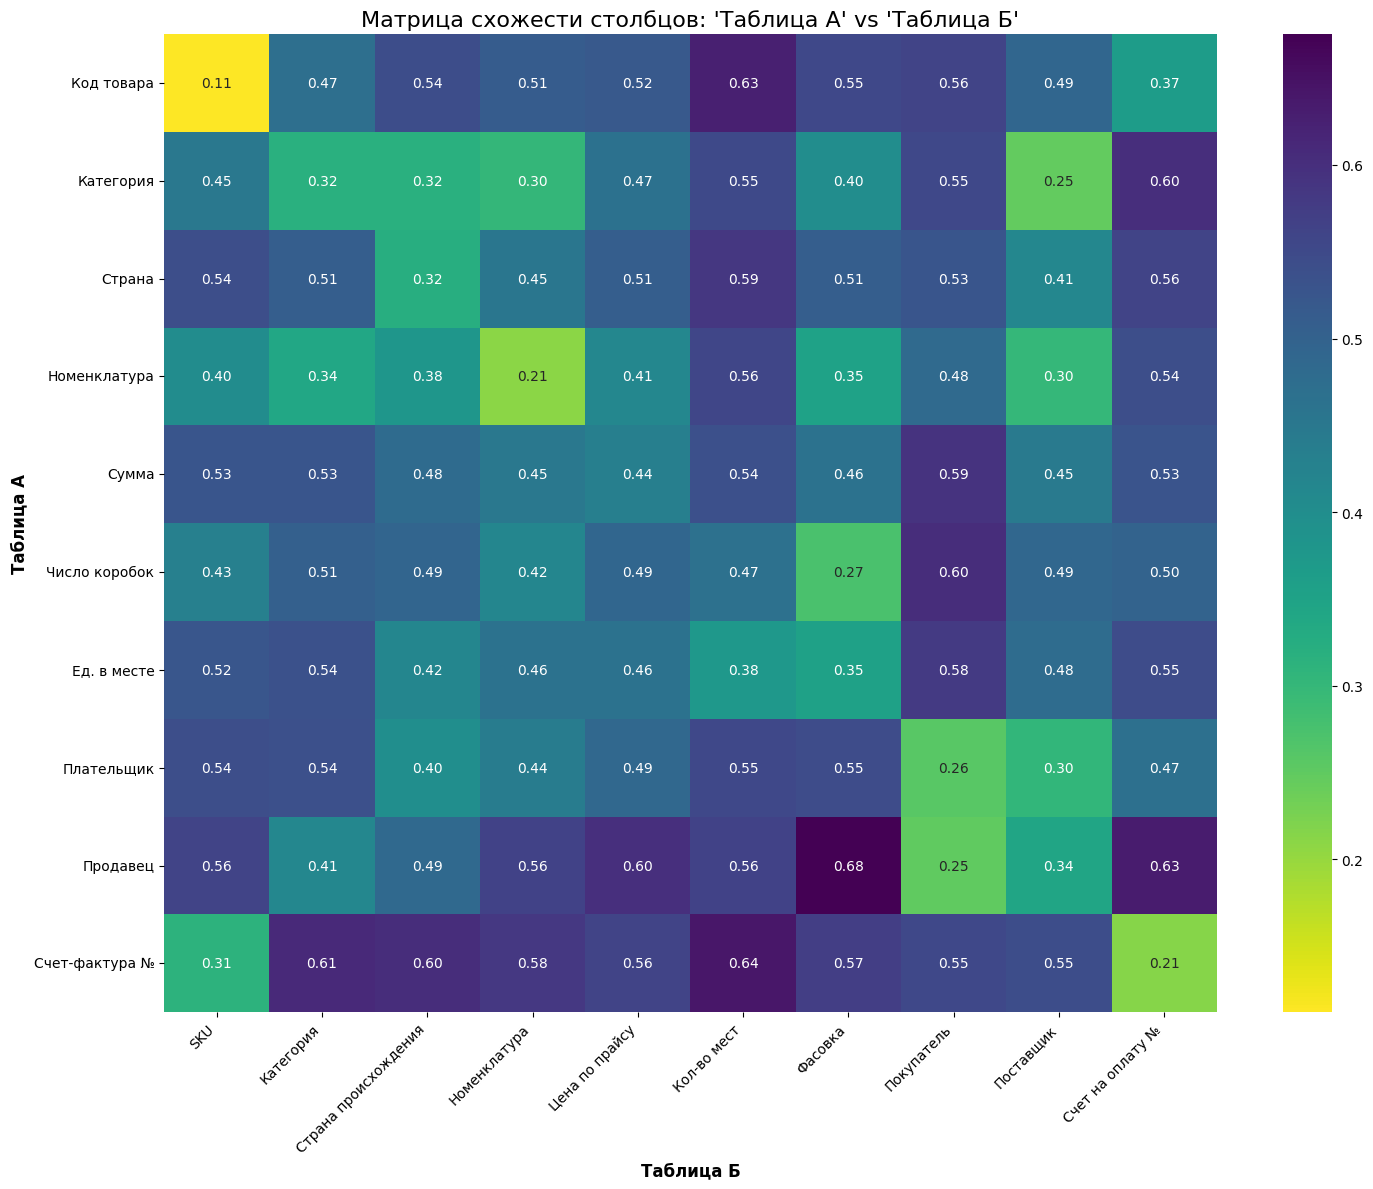

In [16]:
host = 'http://100.74.62.22:11434' 
llm_name = 'gpt-oss:20b'
emb_name = "dengcao/Qwen3-Embedding-0.6B:F16"
#emb_name = "embeddinggemma"
embedder = OllamaEmbedding(host = host, model = emb_name)
llm = OllamaLLM(host = host, model=llm_name)

#Артикул Страна Номенклатура СуммарнаяЦена Количество Покупатель Продавец 

# Таблица А
Serials1 = []
keys1 = ['Код товара','Категория', 'Страна','Номенклатура', 'Сумма', 'Число коробок', 'Ед. в месте']
for key in keys1:
    Serials1.append(EmbSerial(embedder=embedder, llm=llm, name = key, content = dataframe1[key].tolist()))

mets1 = ['Плательщик', 'Продавец', 'Счет-фактура №']
for met in mets1:
    Serials1.append(EmbSerial(embedder=embedder, llm=llm, name = met, content = [metadata1[met]]))

# Таблица Б
Serials2 = []
keys2 = ['SKU', 'Категория', 'Страна происхождения', 'Номенклатура', 'Цена по прайсу', 'Кол-во мест', 'Фасовка']
for key in keys2:
    Serials2.append(EmbSerial(embedder=embedder, llm=llm, name = key, content = dataframe2[key].tolist()))

mets2 = ['Покупатель', 'Поставщик', 'Счет на оплату №']
for met in mets2:
    Serials2.append(EmbSerial(embedder=embedder, llm=llm, name = met, content = [metadata2[met]]))

plot_cross_table_heatmap(
    emb_list_a = Serials1, 
    emb_list_b = Serials2, 
    table_a_name = "Таблица A", 
    table_b_name = "Таблица Б"
)

In [17]:
for Serial in Serials1:
    print(Serial.description)
print('---------')
for Serial in Serials2:
    print(Serial.description)

Уникальный числовой код, идентифицирующий товар (например, EAN/UPC, SKU), состоящий из цифр различной длины.
Категория товаров или услуг, обозначающая общий тип или назначение предмета (например, бытовая химия, упаковка, средства для мытья и прочее).
Наименование страны, к которой относится данная запись.
Наименование товара с указанием бренда, вида, объёма и иных характеристик.
Общая сумма, представляющая количественное значение (например, денежную, количественную или иное), записанная как число с десятичными знаками.
Количество коробок, связанных с каждой записью (например, упакованных, отгруженных или задействованных в операции).
Количество единиц, обнаруженных или зарегистрированных в конкретном месте.
Наименование плательщика (организации, юридического лица или физического лица).
Название продавца (организация или физическое лицо)
Уникальный номер счета‑фактуры, обычно включающий код документа, год, месяц и порядковый номер.
---------
Уникальный код товара (SKU), используемый для 

## cross encoder qwen3 reranker 8b

## Gemma3:27b

Обработка столбца Код товара...
Столбец обработан!
Обработка столбца Категория...
Столбец обработан!
Обработка столбца Страна...
Столбец обработан!
Обработка столбца Номенклатура...
Столбец обработан!
Обработка столбца Сумма...
Столбец обработан!
Обработка столбца Число коробок...
Столбец обработан!
Обработка столбца Ед. в месте...
Столбец обработан!
Обработка столбца Плательщик...
Столбец обработан!
Обработка столбца Продавец...
Столбец обработан!
Обработка столбца Счет-фактура №...
Столбец обработан!
Обработка столбца SKU...
Столбец обработан!
Обработка столбца Категория...
Столбец обработан!
Обработка столбца Страна происхождения...
Столбец обработан!
Обработка столбца Номенклатура...
Столбец обработан!
Обработка столбца Цена по прайсу...
Столбец обработан!
Обработка столбца Кол-во мест...
Столбец обработан!
Обработка столбца Фасовка...
Столбец обработан!
Обработка столбца Покупатель...
Столбец обработан!
Обработка столбца Поставщик...
Столбец обработан!
Обработка столбца Счет на оп

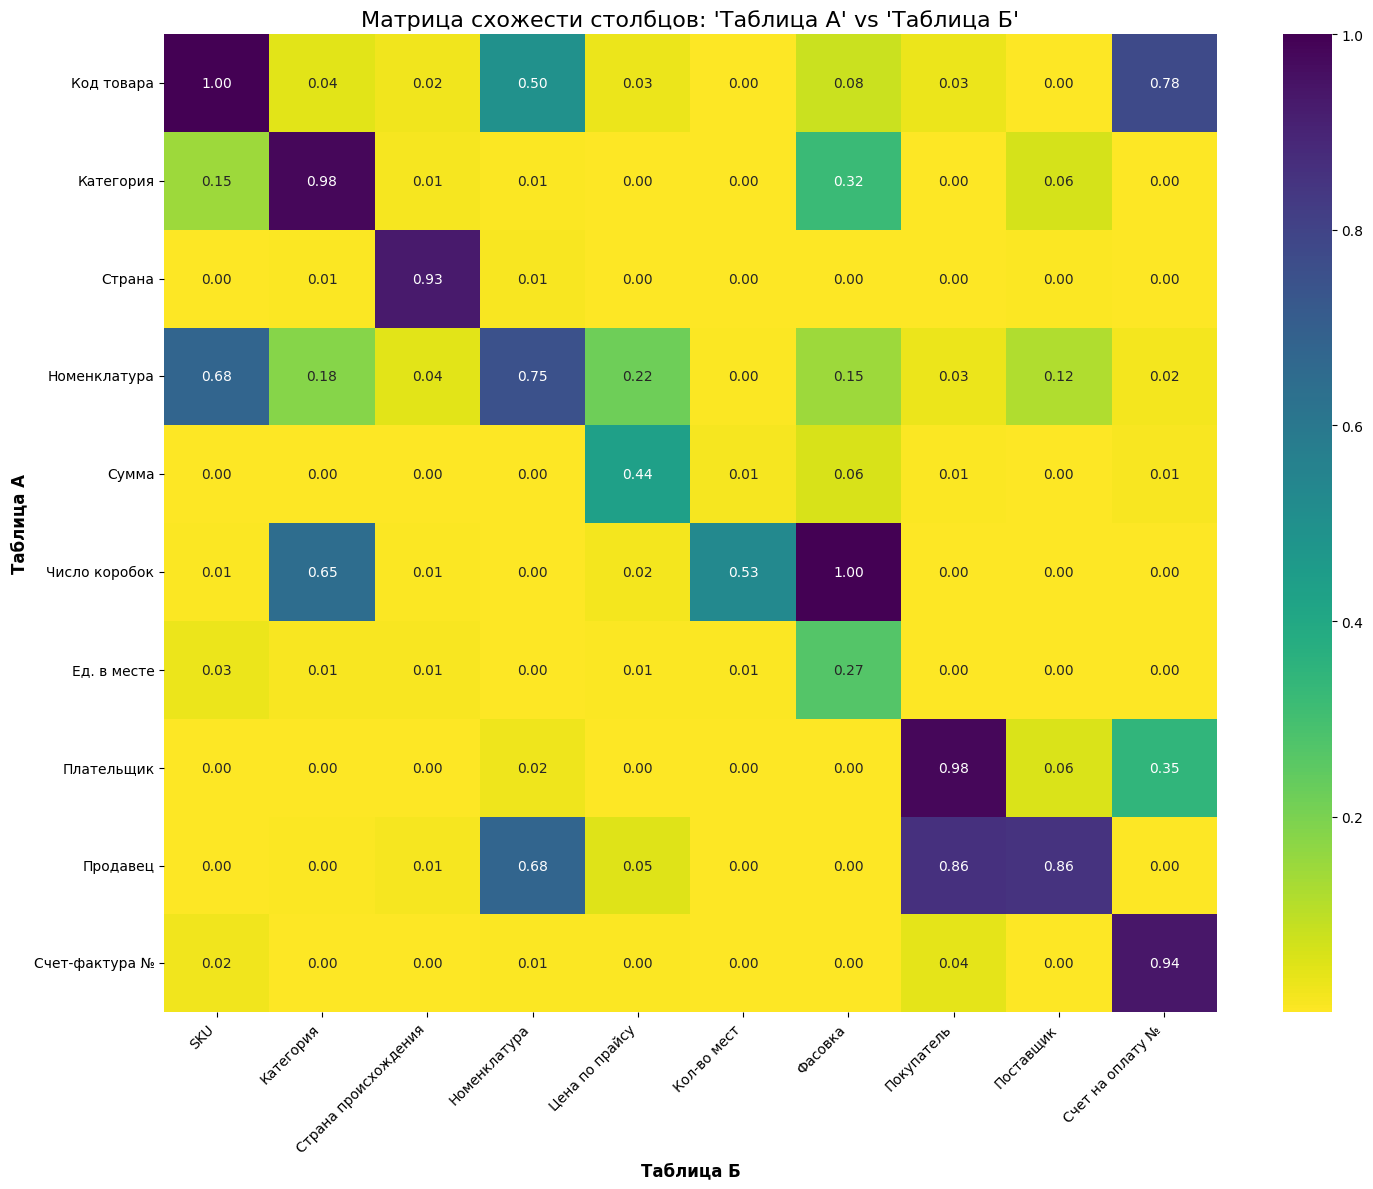

In [10]:
host = 'http://100.74.62.22:11434' 
llm_name = 'gemma3:27b'
emb_name = "dengcao/Qwen3-Embedding-0.6B:F16"
#emb_name = "embeddinggemma"
embedder = OllamaEmbedding(host = host, model = emb_name)
llm = OllamaLLM(host = host, model=llm_name)

#Артикул Страна Номенклатура СуммарнаяЦена Количество Покупатель Продавец 

# Таблица А
Serials1 = []
keys1 = ['Код товара','Категория', 'Страна','Номенклатура', 'Сумма', 'Число коробок', 'Ед. в месте']
for key in keys1:
    Serials1.append(EmbSerial(embedder=embedder, llm=llm, name = key, content = dataframe1[key].tolist()))

mets1 = ['Плательщик', 'Продавец', 'Счет-фактура №']
for met in mets1:
    Serials1.append(EmbSerial(embedder=embedder, llm=llm, name = met, content = [metadata1[met]]))

# Таблица Б
Serials2 = []
keys2 = ['SKU', 'Категория', 'Страна происхождения', 'Номенклатура', 'Цена по прайсу', 'Кол-во мест', 'Фасовка']
for key in keys2:
    Serials2.append(EmbSerial(embedder=embedder, llm=llm, name = key, content = dataframe2[key].tolist()))

mets2 = ['Покупатель', 'Поставщик', 'Счет на оплату №']
for met in mets2:
    Serials2.append(EmbSerial(embedder=embedder, llm=llm, name = met, content = [metadata2[met]]))

plot_cross_table_heatmap_cross_encoder(
    emb_list_a = Serials1, 
    emb_list_b = Serials2, 
    table_a_name = "Таблица A", 
    table_b_name = "Таблица Б"
)

In [11]:
for Serial in Serials1:
    print(Serial.name, ': ',Serial.description)
print('---------')
for Serial in Serials2:
    print(Serial.name, ': ',Serial.description)

Код товара :  Уникальный идентификатор товара. Может использоваться для внутреннего учета и поиска информации о товаре в системе.

Категория :  Группа, к которой относится товар или элемент данных.

Страна :  Географическое местоположение или страна происхождения данных.

Номенклатура :  Наименование товара или услуги, полное описание позиции в ассортименте.

Сумма :  Общая денежная величина, выраженная в числовом формате. Может представлять собой стоимость, оплату, прибыль, расход или любой другой финансовый показатель.

Число коробок :  Количество единиц, сгруппированных в контейнеры или упаковки. Может представлять собой количество товаров, элементов или объектов, упакованных в отдельные коробки или контейнеры.

Ед. в месте :  Количественное значение, связанное с местоположением или позицией. Может представлять номер, индекс, количество или другую числовую характеристику, относящуюся к месту.

Плательщик :  Наименование юридического или физического лица, осуществляющего платеж или и

## gpt-oss:20b

Обработка столбца Код товара...
Столбец обработан!
Обработка столбца Категория...
Столбец обработан!
Обработка столбца Страна...
Столбец обработан!
Обработка столбца Номенклатура...
Столбец обработан!
Обработка столбца Сумма...
Столбец обработан!
Обработка столбца Число коробок...
Столбец обработан!
Обработка столбца Ед. в месте...
Столбец обработан!
Обработка столбца Плательщик...
Столбец обработан!
Обработка столбца Продавец...
Столбец обработан!
Обработка столбца Счет-фактура №...
Столбец обработан!
Обработка столбца SKU...
Столбец обработан!
Обработка столбца Категория...
Столбец обработан!
Обработка столбца Страна происхождения...
Столбец обработан!
Обработка столбца Номенклатура...
Столбец обработан!
Обработка столбца Цена по прайсу...
Столбец обработан!
Обработка столбца Кол-во мест...
Столбец обработан!
Обработка столбца Фасовка...
Столбец обработан!
Обработка столбца Покупатель...
Столбец обработан!
Обработка столбца Поставщик...
Столбец обработан!
Обработка столбца Счет на оп

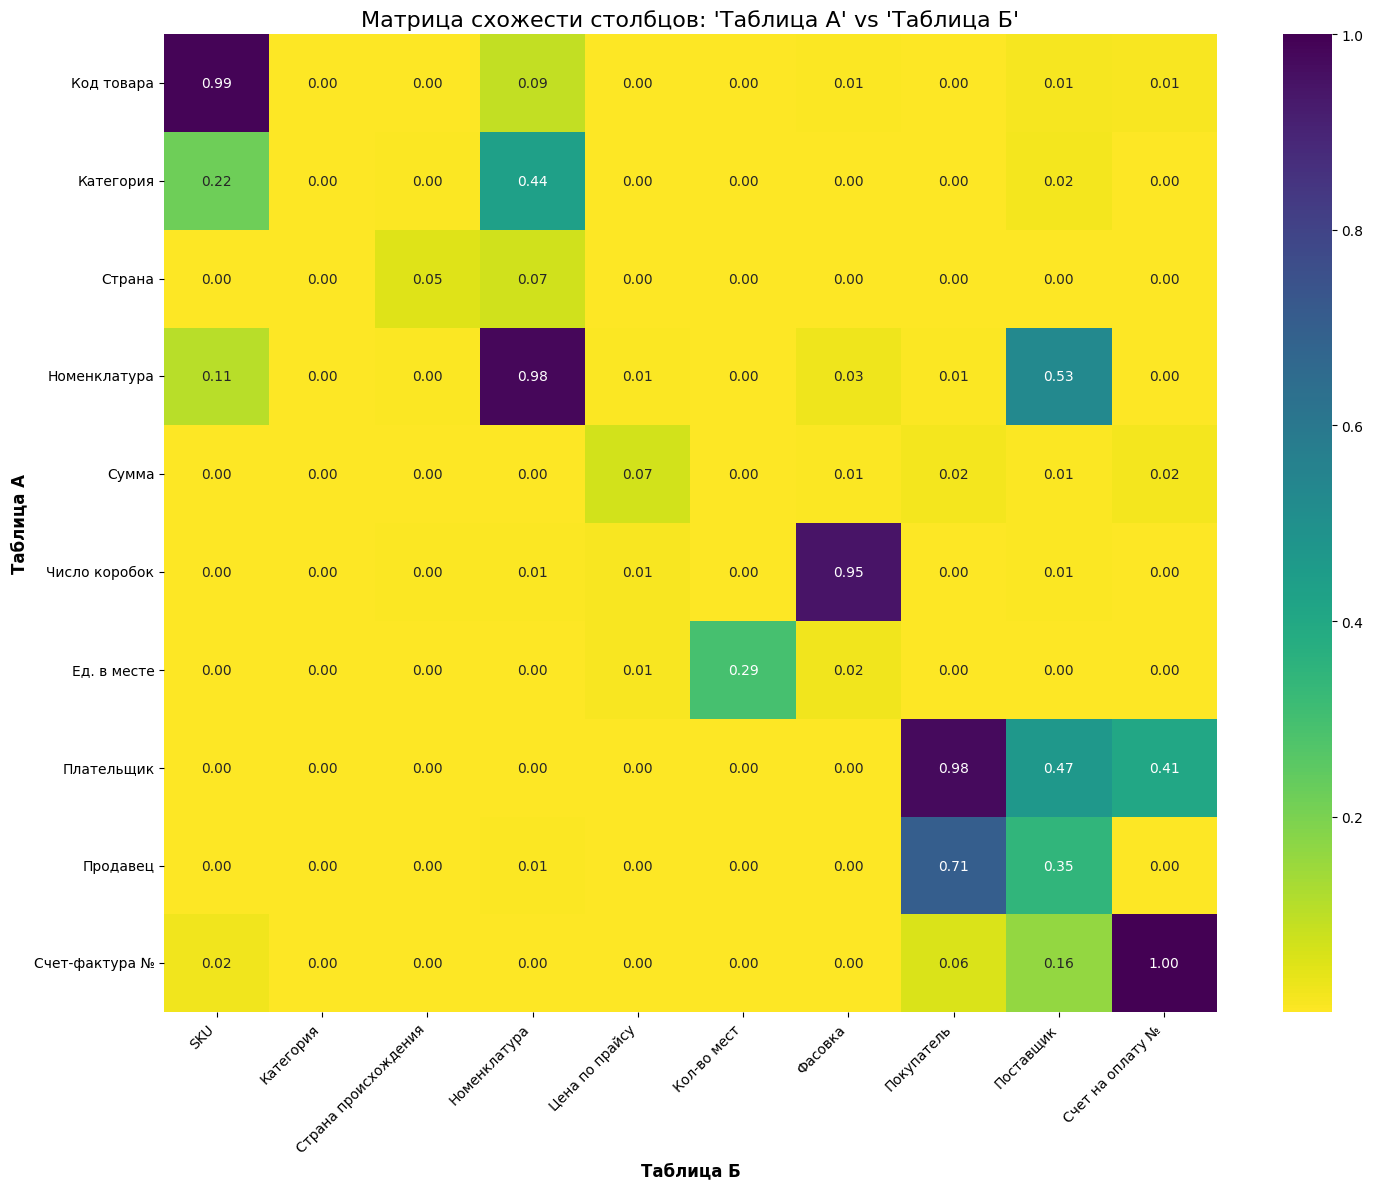

In [8]:
host = 'http://100.74.62.22:11434' 
llm_name = 'gpt-oss:20b'
emb_name = "dengcao/Qwen3-Embedding-0.6B:F16"
#emb_name = "embeddinggemma"
embedder = OllamaEmbedding(host = host, model = emb_name)
llm = OllamaLLM(host = host, model=llm_name)

#Артикул Страна Номенклатура СуммарнаяЦена Количество Покупатель Продавец 

# Таблица А
Serials1 = []
keys1 = ['Код товара','Категория', 'Страна','Номенклатура', 'Сумма', 'Число коробок', 'Ед. в месте']
for key in keys1:
    Serials1.append(EmbSerial(embedder=embedder, llm=llm, name = key, content = dataframe1[key].tolist()))

mets1 = ['Плательщик', 'Продавец', 'Счет-фактура №']
for met in mets1:
    Serials1.append(EmbSerial(embedder=embedder, llm=llm, name = met, content = [metadata1[met]]))

# Таблица Б
Serials2 = []
keys2 = ['SKU', 'Категория', 'Страна происхождения', 'Номенклатура', 'Цена по прайсу', 'Кол-во мест', 'Фасовка']
for key in keys2:
    Serials2.append(EmbSerial(embedder=embedder, llm=llm, name = key, content = dataframe2[key].tolist()))

mets2 = ['Покупатель', 'Поставщик', 'Счет на оплату №']
for met in mets2:
    Serials2.append(EmbSerial(embedder=embedder, llm=llm, name = met, content = [metadata2[met]]))

plot_cross_table_heatmap_cross_encoder(
    emb_list_a = Serials1, 
    emb_list_b = Serials2, 
    table_a_name = "Таблица A", 
    table_b_name = "Таблица Б"
)

In [9]:
for Serial in Serials1:
    print(Serial.name, ': ',Serial.description)
print('---------')
for Serial in Serials2:
    print(Serial.name, ': ',Serial.description)

Код товара :  Числовой идентификатор товара (штрихкод, UPC/EAN или внутренний код), уникальный в пределах каталога.
Категория :  Категория товаров, обозначающая их тип и назначение.
Страна :  Наименование страны
Номенклатура :  Наименование товара (полное описание продукта, включающее бренд, назначение, объём/размер, материал и другие характеристики).
Сумма :  Суммарное значение (числовое, обычно денежное)
Число коробок :  Общее число коробок – количество единиц упаковки, содержащих товар, материалы или другие объекты.
Ед. в месте :  Количество единиц, находящихся в конкретном месте.
Плательщик :  Наименование плательщика (организации, юридического лица или физического лица), осуществляющего оплату.
Продавец :  Наименование продавца (юридического лица, индивидуального предпринимателя или организации)
Счет-фактура № :  Уникальный номер счёта‑фактуры, включающий год, месяц и порядковый номер документа.
---------
SKU :  Уникальный идентификатор товара, состоящий из кодов производителя, ка

## description = f'{self.name}: {self.llm.generate(prompt)}'

Обработка столбца Код товара...
Столбец обработан!
Обработка столбца Категория...
Столбец обработан!
Обработка столбца Страна...
Столбец обработан!
Обработка столбца Номенклатура...
Столбец обработан!
Обработка столбца Сумма...
Столбец обработан!
Обработка столбца Число коробок...
Столбец обработан!
Обработка столбца Ед. в месте...
Столбец обработан!
Обработка столбца Плательщик...
Столбец обработан!
Обработка столбца Продавец...
Столбец обработан!
Обработка столбца Счет-фактура №...
Столбец обработан!
Обработка столбца SKU...
Столбец обработан!
Обработка столбца Категория...
Столбец обработан!
Обработка столбца Страна происхождения...
Столбец обработан!
Обработка столбца Номенклатура...
Столбец обработан!
Обработка столбца Цена по прайсу...
Столбец обработан!
Обработка столбца Кол-во мест...
Столбец обработан!
Обработка столбца Фасовка...
Столбец обработан!
Обработка столбца Покупатель...
Столбец обработан!
Обработка столбца Поставщик...
Столбец обработан!
Обработка столбца Счет на оп

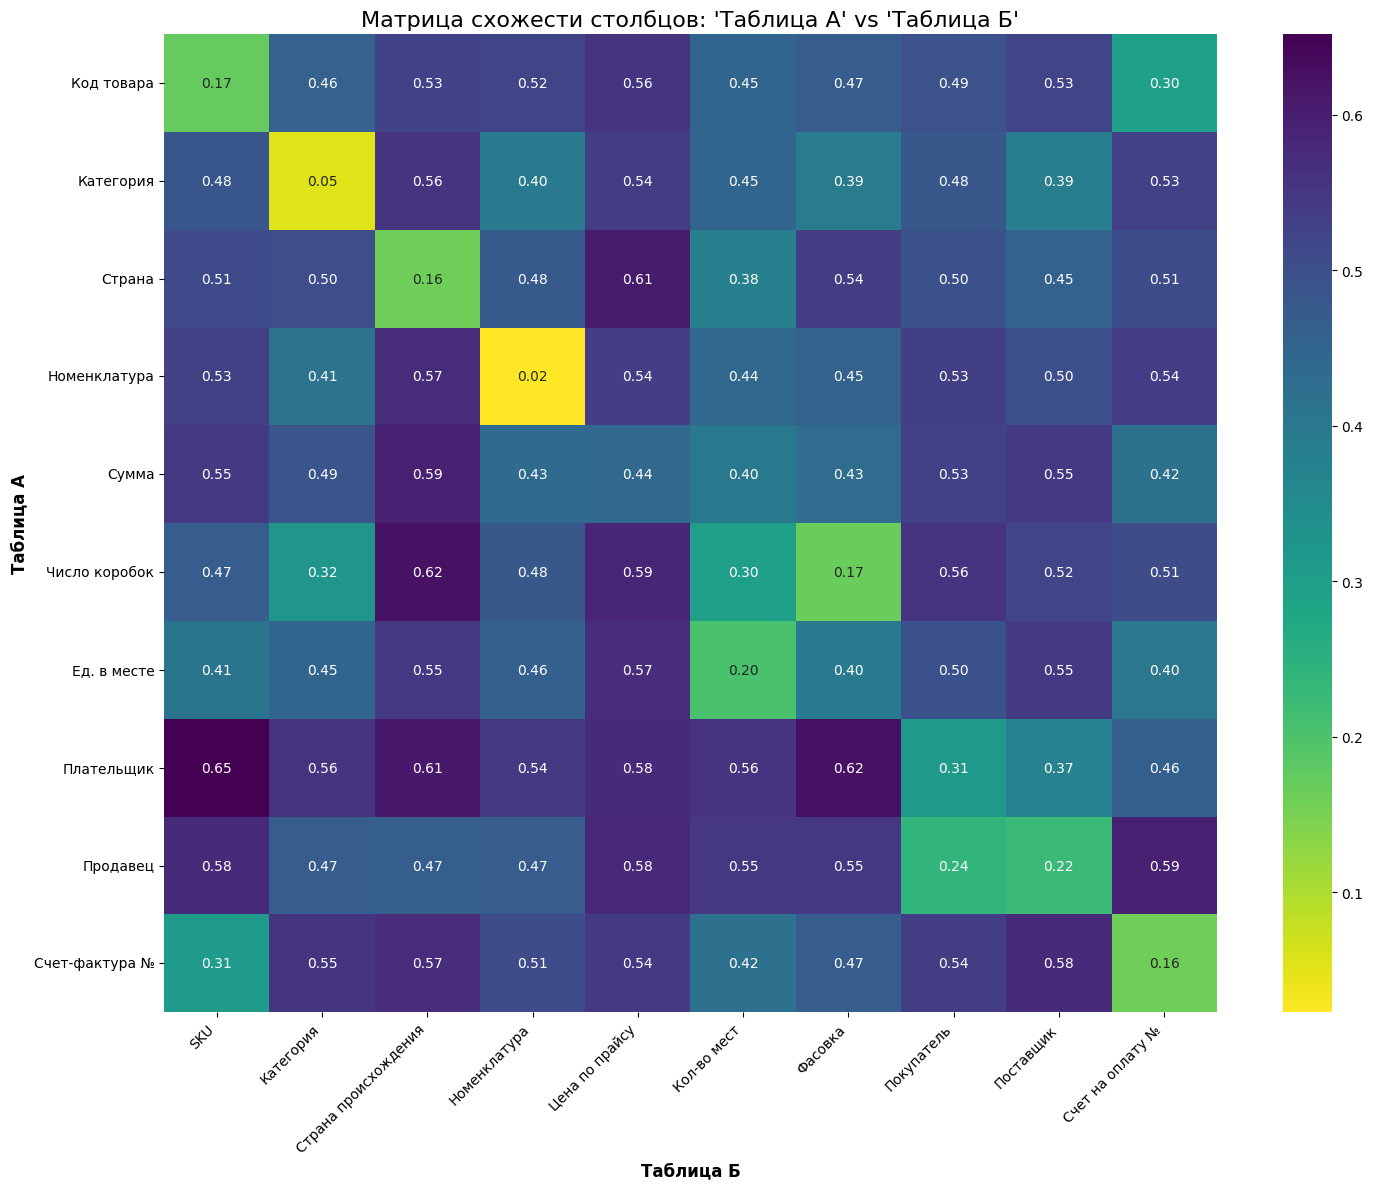

Код товара :  Код товара: Уникальный идентификатор товара. Может использоваться для внутреннего учета и поиска информации о товаре в системе.

Категория :  Категория: Группа, к которой относится товар или услуга.

Страна :  Страна: Географическое или политическое местоположение, к которому относятся данные в строке. Может указывать на страну происхождения, страну регистрации, страну поставки или другую географическую привязку.

Номенклатура :  Номенклатура: Наименование товара или услуги, включая характеристики и объем/количество.

Сумма :  Сумма: Общая денежная величина, выраженная в числовом формате. Может представлять собой стоимость, платеж, баланс или любую другую финансовую метрику.

Число коробок :  Число коробок: Количество единиц в группе или партии. Может представлять собой количество объектов, упаковок, контейнеров или любых других дискретных элементов.

Ед. в месте :  Ед. в месте: Количественная характеристика объекта или позиции. Может представлять собой номер, идентификат

In [3]:
host = 'http://100.74.62.22:11434' 
llm_name = 'gemma3:27b'
emb_name = "dengcao/Qwen3-Embedding-0.6B:F16"
#emb_name = "embeddinggemma"
embedder = OllamaEmbedding(host = host, model = emb_name)
llm = OllamaLLM(host = host, model=llm_name)

#Артикул Страна Номенклатура СуммарнаяЦена Количество Покупатель Продавец 

# Таблица А
Serials1 = []
keys1 = ['Код товара','Категория', 'Страна','Номенклатура', 'Сумма', 'Число коробок', 'Ед. в месте']
for key in keys1:
    Serials1.append(EmbSerial(embedder=embedder, llm=llm, name = key, content = dataframe1[key].tolist()))

mets1 = ['Плательщик', 'Продавец', 'Счет-фактура №']
for met in mets1:
    Serials1.append(EmbSerial(embedder=embedder, llm=llm, name = met, content = [metadata1[met]]))

# Таблица Б
Serials2 = []
keys2 = ['SKU', 'Категория', 'Страна происхождения', 'Номенклатура', 'Цена по прайсу', 'Кол-во мест', 'Фасовка']
for key in keys2:
    Serials2.append(EmbSerial(embedder=embedder, llm=llm, name = key, content = dataframe2[key].tolist()))

mets2 = ['Покупатель', 'Поставщик', 'Счет на оплату №']
for met in mets2:
    Serials2.append(EmbSerial(embedder=embedder, llm=llm, name = met, content = [metadata2[met]]))

plot_cross_table_heatmap(
    emb_list_a = Serials1, 
    emb_list_b = Serials2, 
    table_a_name = "Таблица A", 
    table_b_name = "Таблица Б"
)

for Serial in Serials1:
    print(Serial.name, ': ',Serial.description)
print('---------')
for Serial in Serials2:
    print(Serial.name, ': ',Serial.description)

Обработка столбца Код товара...
Столбец обработан!
Обработка столбца Категория...
Столбец обработан!
Обработка столбца Страна...
Столбец обработан!
Обработка столбца Номенклатура...
Столбец обработан!
Обработка столбца Сумма...
Столбец обработан!
Обработка столбца Число коробок...
Столбец обработан!
Обработка столбца Ед. в месте...
Столбец обработан!
Обработка столбца Плательщик...
Столбец обработан!
Обработка столбца Продавец...
Столбец обработан!
Обработка столбца Счет-фактура №...
Столбец обработан!
Обработка столбца SKU...
Столбец обработан!
Обработка столбца Категория...
Столбец обработан!
Обработка столбца Страна происхождения...
Столбец обработан!
Обработка столбца Номенклатура...
Столбец обработан!
Обработка столбца Цена по прайсу...
Столбец обработан!
Обработка столбца Кол-во мест...
Столбец обработан!
Обработка столбца Фасовка...
Столбец обработан!
Обработка столбца Покупатель...
Столбец обработан!
Обработка столбца Поставщик...
Столбец обработан!
Обработка столбца Счет на оп

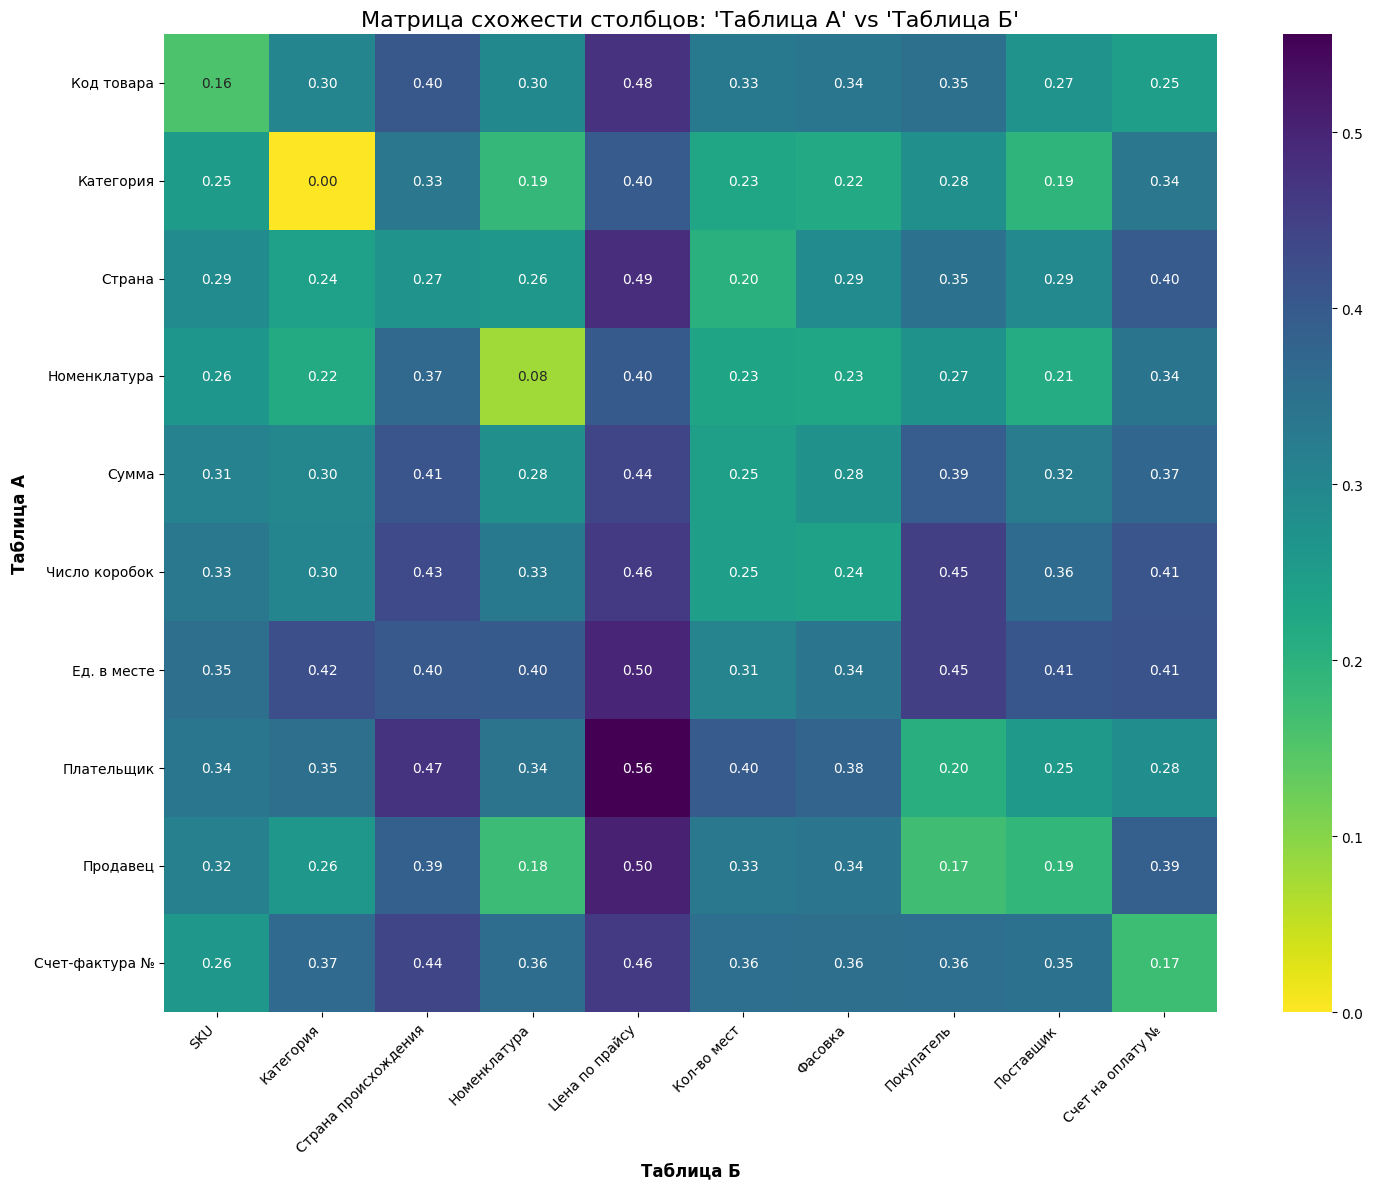

Код товара :  Код товара: Уникальный идентификатор товара. Может использоваться для внутреннего учета, поиска и отслеживания товаров в системе.

Категория :  Категория: Группа, к которой относится товар или услуга.

Страна :  Страна: Географическое местоположение или регион, к которому относится запись.

Номенклатура :  Номенклатура: Наименование товара или услуги, включающее основные характеристики и объем/количество.

Сумма :  Сумма: Общая денежная величина, результат вычислений или накопленная величина.

Число коробок :  Число коробок: Количество единиц (или объектов), сгруппированных в коробки или контейнеры. Может представлять собой любое количество дискретных элементов, упакованных определенным образом.

Ед. в месте :  Ед. в месте: Количественное значение, связанное с местоположением или объектом. Может представлять собой номер, индекс, количество или другую числовую характеристику, идентифицирующую место или элемент.

Плательщик :  Плательщик: Наименование организации или физиче

In [4]:
host = 'http://100.74.62.22:11434' 
llm_name = 'gemma3:27b'
# emb_name = "dengcao/Qwen3-Embedding-0.6B:F16"
emb_name = "embeddinggemma"
embedder = OllamaEmbedding(host = host, model = emb_name)
llm = OllamaLLM(host = host, model=llm_name)

#Артикул Страна Номенклатура СуммарнаяЦена Количество Покупатель Продавец 

# Таблица А
Serials1 = []
keys1 = ['Код товара','Категория', 'Страна','Номенклатура', 'Сумма', 'Число коробок', 'Ед. в месте']
for key in keys1:
    Serials1.append(EmbSerial(embedder=embedder, llm=llm, name = key, content = dataframe1[key].tolist()))

mets1 = ['Плательщик', 'Продавец', 'Счет-фактура №']
for met in mets1:
    Serials1.append(EmbSerial(embedder=embedder, llm=llm, name = met, content = [metadata1[met]]))

# Таблица Б
Serials2 = []
keys2 = ['SKU', 'Категория', 'Страна происхождения', 'Номенклатура', 'Цена по прайсу', 'Кол-во мест', 'Фасовка']
for key in keys2:
    Serials2.append(EmbSerial(embedder=embedder, llm=llm, name = key, content = dataframe2[key].tolist()))

mets2 = ['Покупатель', 'Поставщик', 'Счет на оплату №']
for met in mets2:
    Serials2.append(EmbSerial(embedder=embedder, llm=llm, name = met, content = [metadata2[met]]))

plot_cross_table_heatmap(
    emb_list_a = Serials1, 
    emb_list_b = Serials2, 
    table_a_name = "Таблица A", 
    table_b_name = "Таблица Б"
)

for Serial in Serials1:
    print(Serial.name, ': ',Serial.description)
print('---------')
for Serial in Serials2:
    print(Serial.name, ': ',Serial.description)

Обработка столбца Код товара...
Столбец обработан!
Обработка столбца Категория...
Столбец обработан!
Обработка столбца Страна...
Столбец обработан!
Обработка столбца Номенклатура...
Столбец обработан!
Обработка столбца Сумма...
Столбец обработан!
Обработка столбца Число коробок...
Столбец обработан!
Обработка столбца Ед. в месте...
Столбец обработан!
Обработка столбца Плательщик...
Столбец обработан!
Обработка столбца Продавец...
Столбец обработан!
Обработка столбца Счет-фактура №...
Столбец обработан!
Обработка столбца SKU...
Столбец обработан!
Обработка столбца Категория...
Столбец обработан!
Обработка столбца Страна происхождения...
Столбец обработан!
Обработка столбца Номенклатура...
Столбец обработан!
Обработка столбца Цена по прайсу...
Столбец обработан!
Обработка столбца Кол-во мест...
Столбец обработан!
Обработка столбца Фасовка...
Столбец обработан!
Обработка столбца Покупатель...
Столбец обработан!
Обработка столбца Поставщик...
Столбец обработан!
Обработка столбца Счет на оп

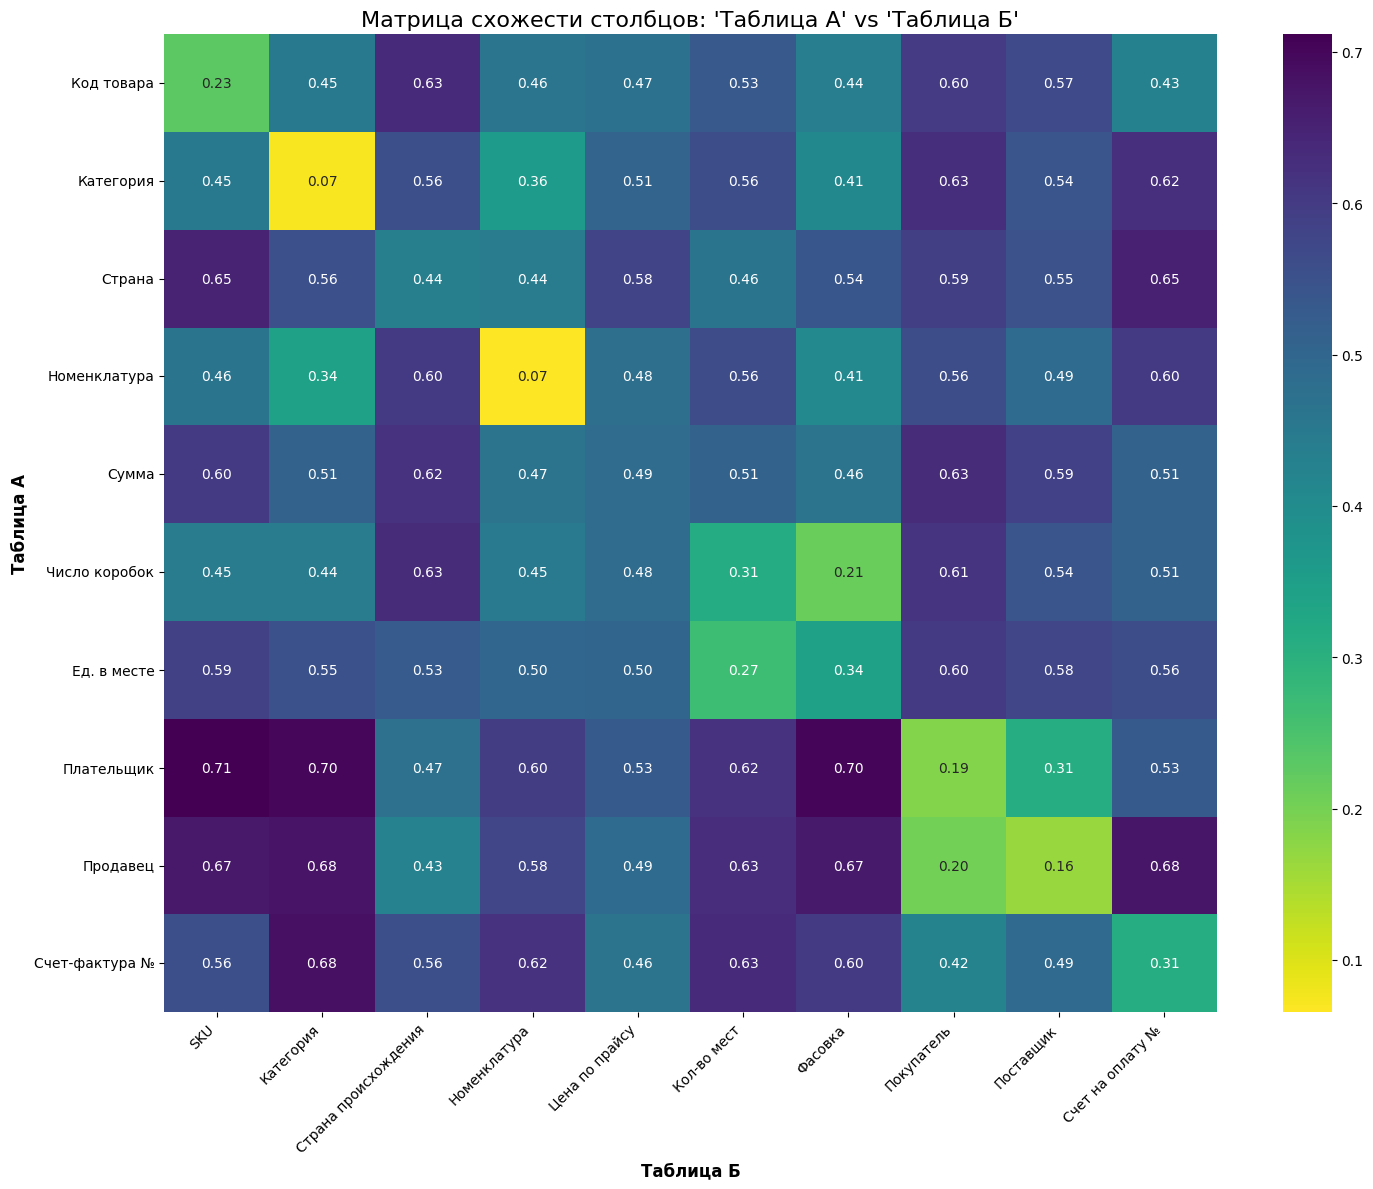

Код товара :  Код товара: Уникальный числовой идентификатор товара, обычно используемый как штрих‑код (EAN/UPC) или внутренний номер каталога.
Категория :  Категория: Категория продукта, обозначающая его тип и область применения (например, бытовая химия, упаковка, средства для мытья).
Страна :  Страна: Наименование страны, в которой находится объект или происходит действие.
Номенклатура :  Номенклатура: Наименование товара с указанием вида, бренда, объёма/размера, упаковки и ключевых характеристик.
Сумма :  Сумма: Числовое значение, представляющее суммарную величину (например, денежный оборот, расходы, доходы и т.п.).
Число коробок :  Число коробок: Количество коробок, содержащих товары или объекты.
Ед. в месте :  Ед. в месте: Количество единиц, находящихся в конкретном месте.
Плательщик :  Плательщик: Наименование плательщика (организации или физического лица)
Продавец :  Продавец: Наименование продавца (организации, компании или физического лица)
Счет-фактура № :  Счет-фактура №: Ном

In [6]:
host = 'http://100.74.62.22:11434' 
llm_name = 'gpt-oss:20b'
emb_name = "dengcao/Qwen3-Embedding-0.6B:F16"
#emb_name = "embeddinggemma"
embedder = OllamaEmbedding(host = host, model = emb_name)
llm = OllamaLLM(host = host, model=llm_name)

#Артикул Страна Номенклатура СуммарнаяЦена Количество Покупатель Продавец 

# Таблица А
Serials1 = []
keys1 = ['Код товара','Категория', 'Страна','Номенклатура', 'Сумма', 'Число коробок', 'Ед. в месте']
for key in keys1:
    Serials1.append(EmbSerial(embedder=embedder, llm=llm, name = key, content = dataframe1[key].tolist()))

mets1 = ['Плательщик', 'Продавец', 'Счет-фактура №']
for met in mets1:
    Serials1.append(EmbSerial(embedder=embedder, llm=llm, name = met, content = [metadata1[met]]))

# Таблица Б
Serials2 = []
keys2 = ['SKU', 'Категория', 'Страна происхождения', 'Номенклатура', 'Цена по прайсу', 'Кол-во мест', 'Фасовка']
for key in keys2:
    Serials2.append(EmbSerial(embedder=embedder, llm=llm, name = key, content = dataframe2[key].tolist()))

mets2 = ['Покупатель', 'Поставщик', 'Счет на оплату №']
for met in mets2:
    Serials2.append(EmbSerial(embedder=embedder, llm=llm, name = met, content = [metadata2[met]]))

plot_cross_table_heatmap(
    emb_list_a = Serials1, 
    emb_list_b = Serials2, 
    table_a_name = "Таблица A", 
    table_b_name = "Таблица Б"
)

for Serial in Serials1:
    print(Serial.name, ': ',Serial.description)
print('---------')
for Serial in Serials2:
    print(Serial.name, ': ',Serial.description)

Обработка столбца Код товара...
Столбец обработан!
Обработка столбца Категория...
Столбец обработан!
Обработка столбца Страна...
Столбец обработан!
Обработка столбца Номенклатура...
Столбец обработан!
Обработка столбца Сумма...
Столбец обработан!
Обработка столбца Число коробок...
Столбец обработан!
Обработка столбца Ед. в месте...
Столбец обработан!
Обработка столбца Плательщик...
Столбец обработан!
Обработка столбца Продавец...
Столбец обработан!
Обработка столбца Счет-фактура №...
Столбец обработан!
Обработка столбца SKU...
Столбец обработан!
Обработка столбца Категория...
Столбец обработан!
Обработка столбца Страна происхождения...
Столбец обработан!
Обработка столбца Номенклатура...
Столбец обработан!
Обработка столбца Цена по прайсу...
Столбец обработан!
Обработка столбца Кол-во мест...
Столбец обработан!
Обработка столбца Фасовка...
Столбец обработан!
Обработка столбца Покупатель...
Столбец обработан!
Обработка столбца Поставщик...
Столбец обработан!
Обработка столбца Счет на оп

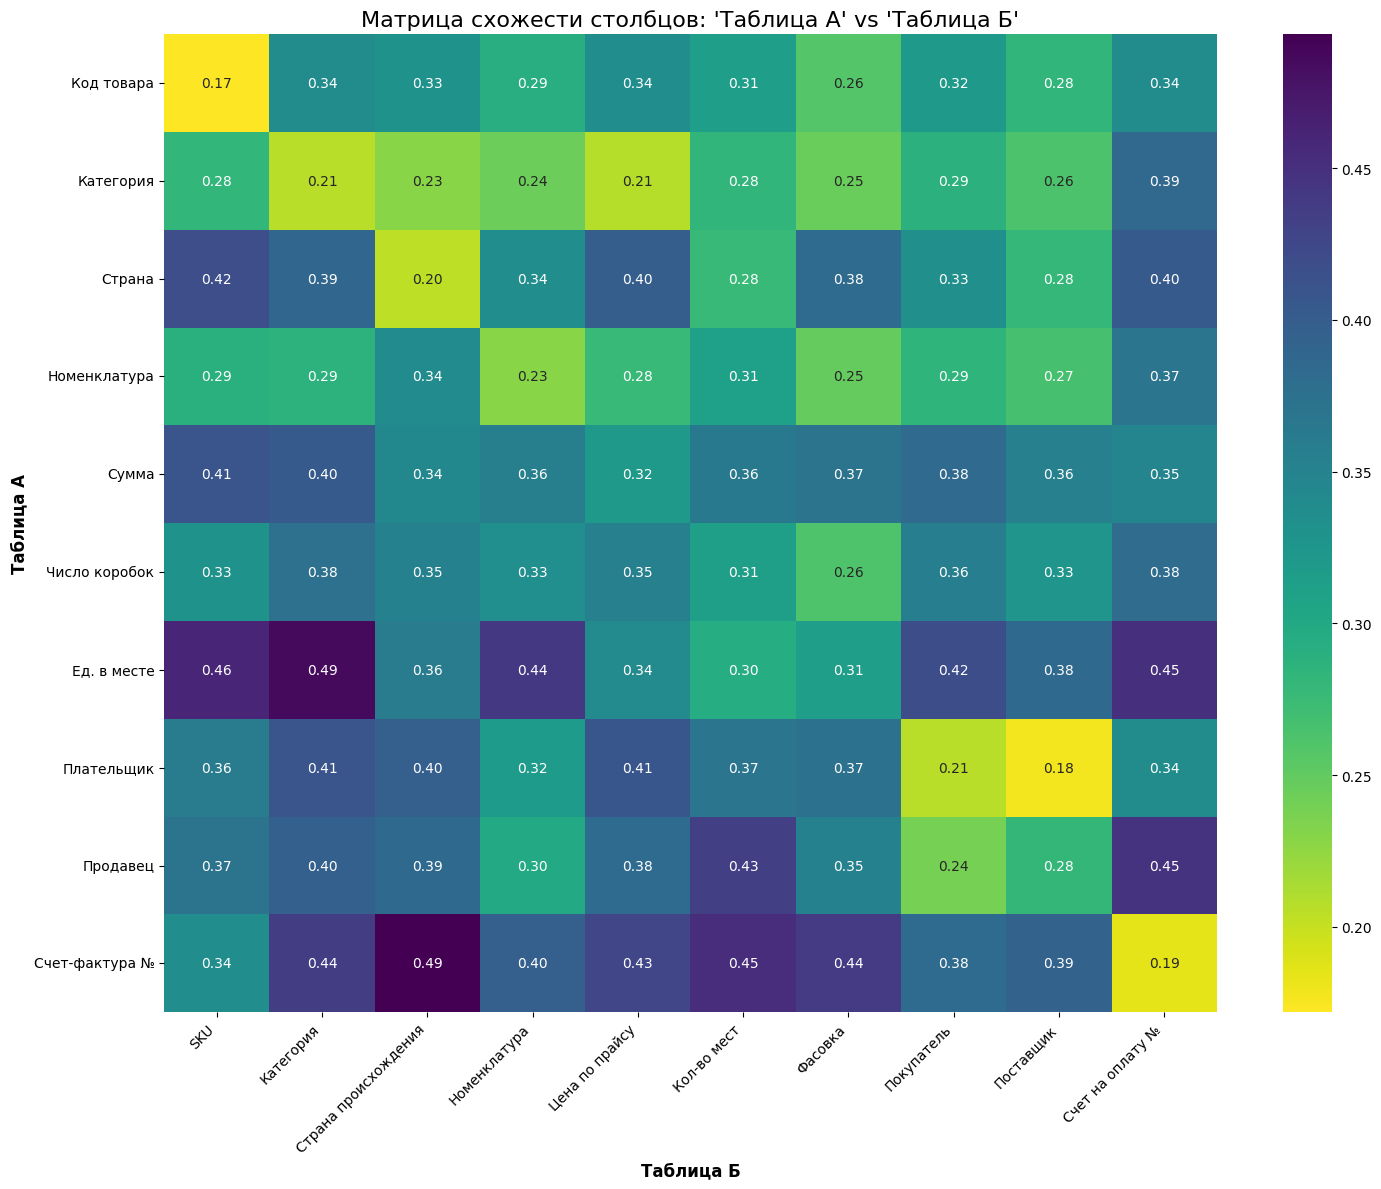

Код товара :  Код товара: Уникальный идентификатор товара (внутренний код, EAN/UPC и пр.)
Категория :  Категория: Общая категория товара (тип продукта)
Страна :  Страна: Наименование страны, в которой происходят события, расположены объекты или выполняется действие.
Номенклатура :  Номенклатура: Наименование товара с ключевыми характеристиками (тип, размер, материал, объём, количество и т.п.).
Сумма :  Сумма: Общая сумма денежных средств, выраженная в валюте.
Число коробок :  Число коробок: Число коробок – количество единиц упаковки (коробок), содержащихся в наборе, комплекте или поставке.
Ед. в месте :  Ед. в месте: Количество единиц, находящихся в конкретном месте.
Плательщик :  Плательщик: Наименование плательщика (организации или физического лица, осуществляющего платеж)
Продавец :  Продавец: Наименование продавца (физического или юридического лица, осуществляющего продажу товаров/услуг)
Счет-фактура № :  Счет-фактура №: Номер счета‑фактуры, включающий код, год, месяц и порядковый 

In [7]:
host = 'http://100.74.62.22:11434' 
llm_name = 'gpt-oss:20b'
# emb_name = "dengcao/Qwen3-Embedding-0.6B:F16"
emb_name = "embeddinggemma"
embedder = OllamaEmbedding(host = host, model = emb_name)
llm = OllamaLLM(host = host, model=llm_name)

#Артикул Страна Номенклатура СуммарнаяЦена Количество Покупатель Продавец 

# Таблица А
Serials1 = []
keys1 = ['Код товара','Категория', 'Страна','Номенклатура', 'Сумма', 'Число коробок', 'Ед. в месте']
for key in keys1:
    Serials1.append(EmbSerial(embedder=embedder, llm=llm, name = key, content = dataframe1[key].tolist()))

mets1 = ['Плательщик', 'Продавец', 'Счет-фактура №']
for met in mets1:
    Serials1.append(EmbSerial(embedder=embedder, llm=llm, name = met, content = [metadata1[met]]))

# Таблица Б
Serials2 = []
keys2 = ['SKU', 'Категория', 'Страна происхождения', 'Номенклатура', 'Цена по прайсу', 'Кол-во мест', 'Фасовка']
for key in keys2:
    Serials2.append(EmbSerial(embedder=embedder, llm=llm, name = key, content = dataframe2[key].tolist()))

mets2 = ['Покупатель', 'Поставщик', 'Счет на оплату №']
for met in mets2:
    Serials2.append(EmbSerial(embedder=embedder, llm=llm, name = met, content = [metadata2[met]]))

plot_cross_table_heatmap(
    emb_list_a = Serials1, 
    emb_list_b = Serials2, 
    table_a_name = "Таблица A", 
    table_b_name = "Таблица Б"
)

for Serial in Serials1:
    print(Serial.name, ': ',Serial.description)
print('---------')
for Serial in Serials2:
    print(Serial.name, ': ',Serial.description)

## cross encoder

Обработка столбца Код товара...
Столбец обработан!
Обработка столбца Категория...
Столбец обработан!
Обработка столбца Страна...
Столбец обработан!
Обработка столбца Номенклатура...
Столбец обработан!
Обработка столбца Сумма...
Столбец обработан!
Обработка столбца Число коробок...
Столбец обработан!
Обработка столбца Ед. в месте...
Столбец обработан!
Обработка столбца Плательщик...
Столбец обработан!
Обработка столбца Продавец...
Столбец обработан!
Обработка столбца Счет-фактура №...
Столбец обработан!
Обработка столбца SKU...
Столбец обработан!
Обработка столбца Категория...
Столбец обработан!
Обработка столбца Страна происхождения...
Столбец обработан!
Обработка столбца Номенклатура...
Столбец обработан!
Обработка столбца Цена по прайсу...
Столбец обработан!
Обработка столбца Кол-во мест...
Столбец обработан!
Обработка столбца Фасовка...
Столбец обработан!
Обработка столбца Покупатель...
Столбец обработан!
Обработка столбца Поставщик...
Столбец обработан!
Обработка столбца Счет на оп

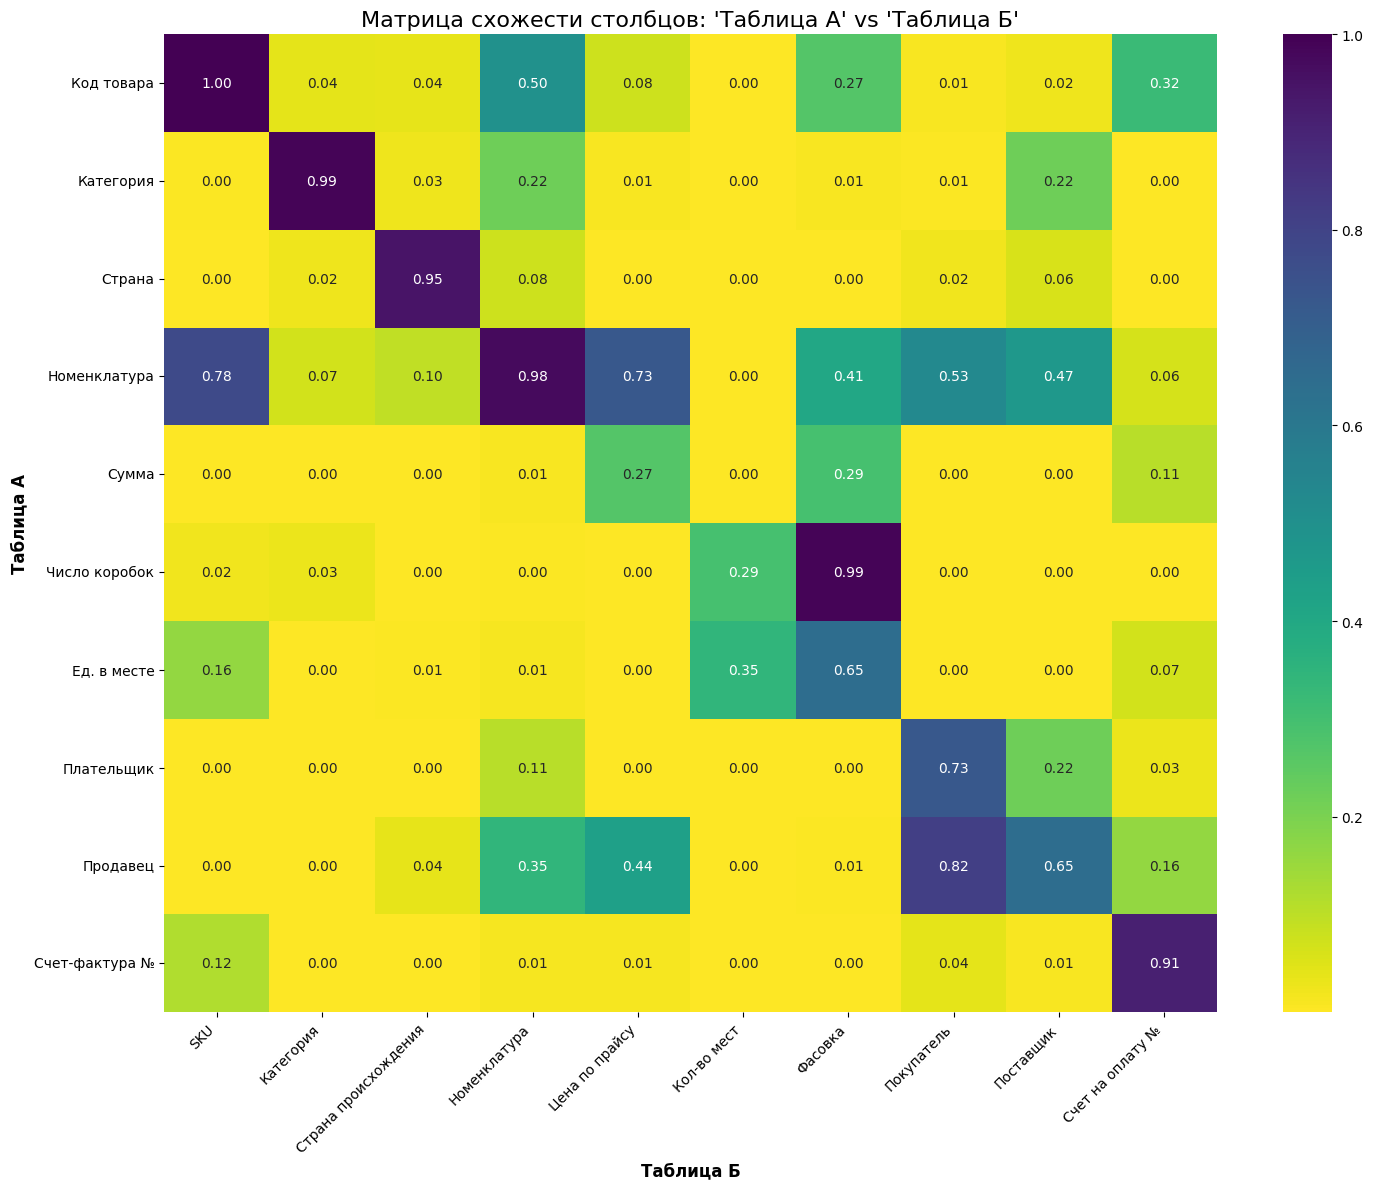

Код товара :  Код товара: Уникальный идентификатор товара. Может использоваться для поиска, учета и отслеживания товаров в системе.

Категория :  Категория: Группа, к которой относится товар или услуга.

Страна :  Страна: Географическое местоположение или страна происхождения данных.

Номенклатура :  Номенклатура: Наименование товара или услуги, полное описание позиции в ассортименте.

Сумма :  Сумма: Общая денежная величина, выраженная в числовом формате. Может представлять собой стоимость, оплату, баланс или другую финансовую метрику.

Число коробок :  Число коробок: Количество единиц (предметов, объектов) в коробках или упаковках. Может представлять собой любое количество чего-либо, сгруппированного в контейнеры.

Ед. в месте :  Ед. в месте: Количественный показатель, связанный с местоположением или объектом. Может представлять собой номер, индекс, код или другую числовую характеристику, идентифицирующую место или объект.

Плательщик :  Плательщик: Наименование юридического или физи

In [10]:
host = 'http://100.74.62.22:11434' 
llm_name = 'gemma3:27b'
# emb_name = "dengcao/Qwen3-Embedding-0.6B:F16"
emb_name = "embeddinggemma"
embedder = OllamaEmbedding(host = host, model = emb_name)
llm = OllamaLLM(host = host, model=llm_name)

#Артикул Страна Номенклатура СуммарнаяЦена Количество Покупатель Продавец 

# Таблица А
Serials1 = []
keys1 = ['Код товара','Категория', 'Страна','Номенклатура', 'Сумма', 'Число коробок', 'Ед. в месте']
for key in keys1:
    Serials1.append(EmbSerial(embedder=embedder, llm=llm, name = key, content = dataframe1[key].tolist()))

mets1 = ['Плательщик', 'Продавец', 'Счет-фактура №']
for met in mets1:
    Serials1.append(EmbSerial(embedder=embedder, llm=llm, name = met, content = [metadata1[met]]))

# Таблица Б
Serials2 = []
keys2 = ['SKU', 'Категория', 'Страна происхождения', 'Номенклатура', 'Цена по прайсу', 'Кол-во мест', 'Фасовка']
for key in keys2:
    Serials2.append(EmbSerial(embedder=embedder, llm=llm, name = key, content = dataframe2[key].tolist()))

mets2 = ['Покупатель', 'Поставщик', 'Счет на оплату №']
for met in mets2:
    Serials2.append(EmbSerial(embedder=embedder, llm=llm, name = met, content = [metadata2[met]]))

plot_cross_table_heatmap_cross_encoder(
    emb_list_a = Serials1, 
    emb_list_b = Serials2, 
    table_a_name = "Таблица A", 
    table_b_name = "Таблица Б"
)

for Serial in Serials1:
    print(Serial.name, ': ',Serial.description)
print('---------')
for Serial in Serials2:
    print(Serial.name, ': ',Serial.description)

Обработка столбца Код товара...
Столбец обработан!
Обработка столбца Категория...
Столбец обработан!
Обработка столбца Страна...
Столбец обработан!
Обработка столбца Номенклатура...
Столбец обработан!
Обработка столбца Сумма...
Столбец обработан!
Обработка столбца Число коробок...
Столбец обработан!
Обработка столбца Ед. в месте...
Столбец обработан!
Обработка столбца Плательщик...
Столбец обработан!
Обработка столбца Продавец...
Столбец обработан!
Обработка столбца Счет-фактура №...
Столбец обработан!
Обработка столбца SKU...
Столбец обработан!
Обработка столбца Категория...
Столбец обработан!
Обработка столбца Страна происхождения...
Столбец обработан!
Обработка столбца Номенклатура...
Столбец обработан!
Обработка столбца Цена по прайсу...
Столбец обработан!
Обработка столбца Кол-во мест...
Столбец обработан!
Обработка столбца Фасовка...
Столбец обработан!
Обработка столбца Покупатель...
Столбец обработан!
Обработка столбца Поставщик...
Столбец обработан!
Обработка столбца Счет на оп

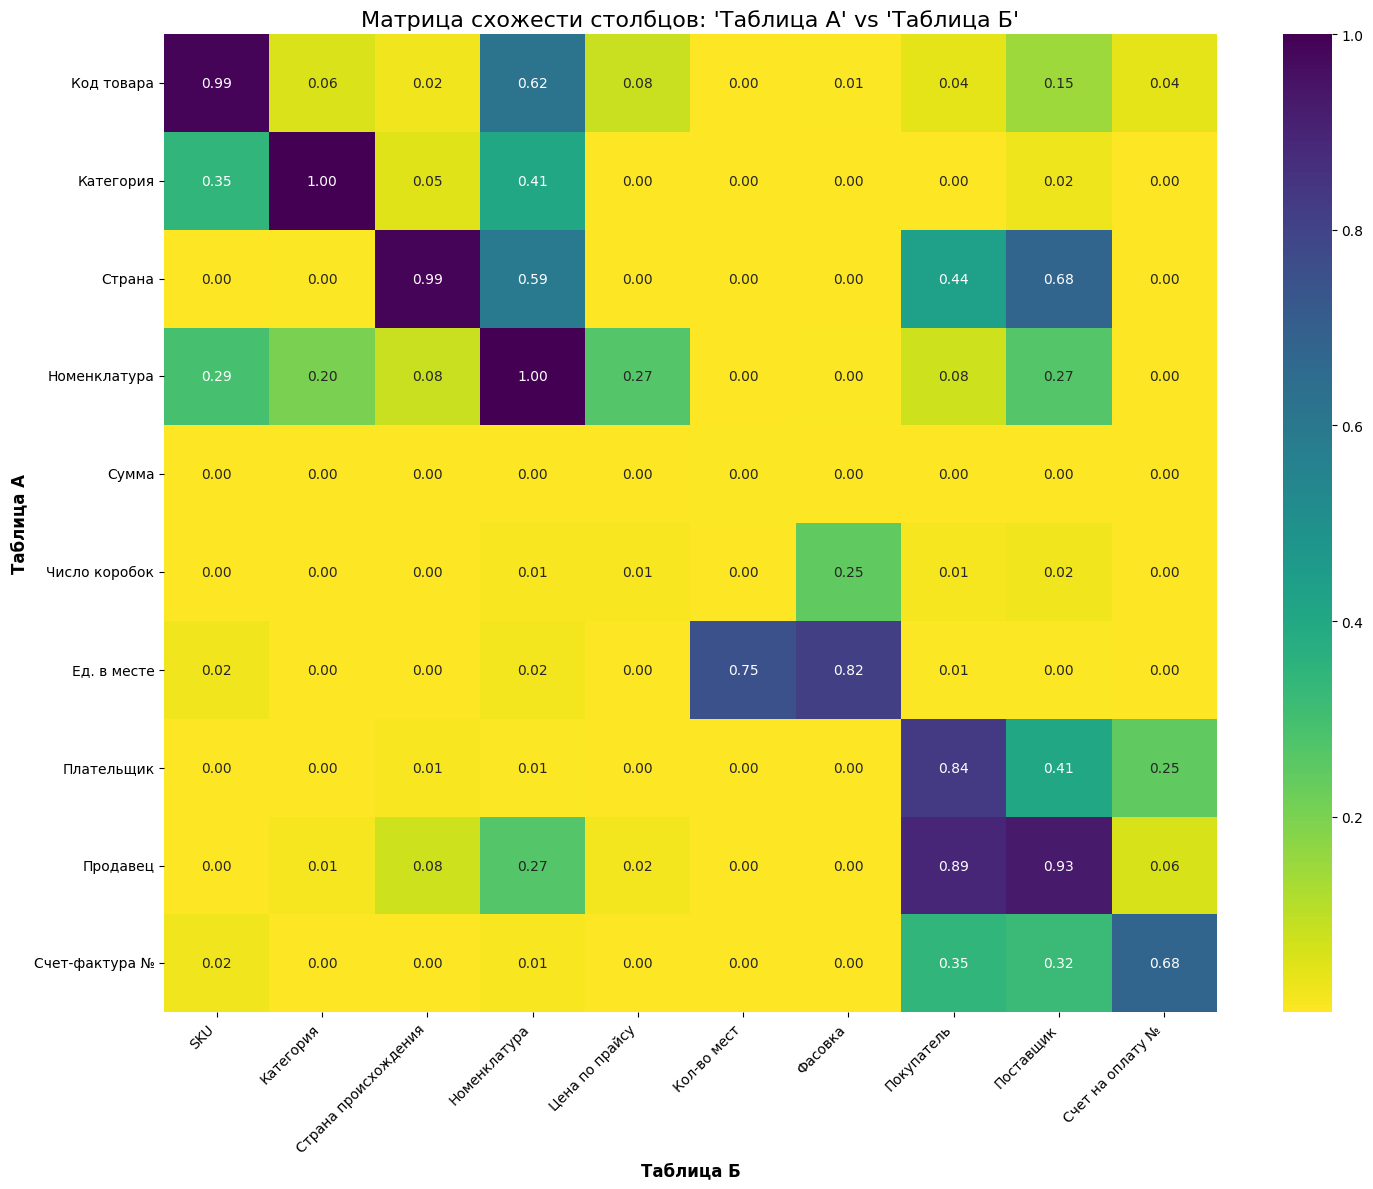

Код товара :  Код товара: Уникальный цифровой код, идентифицирующий товар.
Категория :  Категория: Категория продукта, обозначающая тип или область применения (например, бытовая химия, упаковка, средства для мытья).
Страна :  Страна: Наименование страны, в которой находится объект, производится товар или находится компания.
Номенклатура :  Номенклатура: Наименование товара с указанием модели, размера, объёма, материала и иных характеристик.
Сумма :  Сумма: Общая величина, выраженная числовым значением (например, денежная сумма)
Число коробок :  Число коробок: Количество коробок, связанных с каждой записью.
Ед. в месте :  Ед. в месте: Количество единиц, находящихся в конкретном месте (например, на складе, в отделении, в помещении).
Плательщик :  Плательщик: Наименование плательщика (физическое или юридическое лицо, осуществляющее платежи)
Продавец :  Продавец: Наименование продавца (организации или лица, осуществляющего продажу)
Счет-фактура № :  Счет-фактура №: Уникальный номер счета‑ф

In [11]:
host = 'http://100.74.62.22:11434' 
llm_name = 'gpt-oss:20b'
# emb_name = "dengcao/Qwen3-Embedding-0.6B:F16"
emb_name = "embeddinggemma"
embedder = OllamaEmbedding(host = host, model = emb_name)
llm = OllamaLLM(host = host, model=llm_name)

#Артикул Страна Номенклатура СуммарнаяЦена Количество Покупатель Продавец 

# Таблица А
Serials1 = []
keys1 = ['Код товара','Категория', 'Страна','Номенклатура', 'Сумма', 'Число коробок', 'Ед. в месте']
for key in keys1:
    Serials1.append(EmbSerial(embedder=embedder, llm=llm, name = key, content = dataframe1[key].tolist()))

mets1 = ['Плательщик', 'Продавец', 'Счет-фактура №']
for met in mets1:
    Serials1.append(EmbSerial(embedder=embedder, llm=llm, name = met, content = [metadata1[met]]))

# Таблица Б
Serials2 = []
keys2 = ['SKU', 'Категория', 'Страна происхождения', 'Номенклатура', 'Цена по прайсу', 'Кол-во мест', 'Фасовка']
for key in keys2:
    Serials2.append(EmbSerial(embedder=embedder, llm=llm, name = key, content = dataframe2[key].tolist()))

mets2 = ['Покупатель', 'Поставщик', 'Счет на оплату №']
for met in mets2:
    Serials2.append(EmbSerial(embedder=embedder, llm=llm, name = met, content = [metadata2[met]]))

plot_cross_table_heatmap_cross_encoder(
    emb_list_a = Serials1, 
    emb_list_b = Serials2, 
    table_a_name = "Таблица A", 
    table_b_name = "Таблица Б"
)

for Serial in Serials1:
    print(Serial.name, ': ',Serial.description)
print('---------')
for Serial in Serials2:
    print(Serial.name, ': ',Serial.description)

## description = f'{self.name}'

Обработка столбца Код товара...
Столбец обработан!
Обработка столбца Категория...
Столбец обработан!
Обработка столбца Страна...
Столбец обработан!
Обработка столбца Номенклатура...
Столбец обработан!
Обработка столбца Сумма...
Столбец обработан!
Обработка столбца Число коробок...
Столбец обработан!
Обработка столбца Ед. в месте...
Столбец обработан!
Обработка столбца Плательщик...
Столбец обработан!
Обработка столбца Продавец...
Столбец обработан!
Обработка столбца Счет-фактура №...
Столбец обработан!
Обработка столбца SKU...
Столбец обработан!
Обработка столбца Категория...
Столбец обработан!
Обработка столбца Страна происхождения...
Столбец обработан!
Обработка столбца Номенклатура...
Столбец обработан!
Обработка столбца Цена по прайсу...
Столбец обработан!
Обработка столбца Кол-во мест...
Столбец обработан!
Обработка столбца Фасовка...
Столбец обработан!
Обработка столбца Покупатель...
Столбец обработан!
Обработка столбца Поставщик...
Столбец обработан!
Обработка столбца Счет на оп

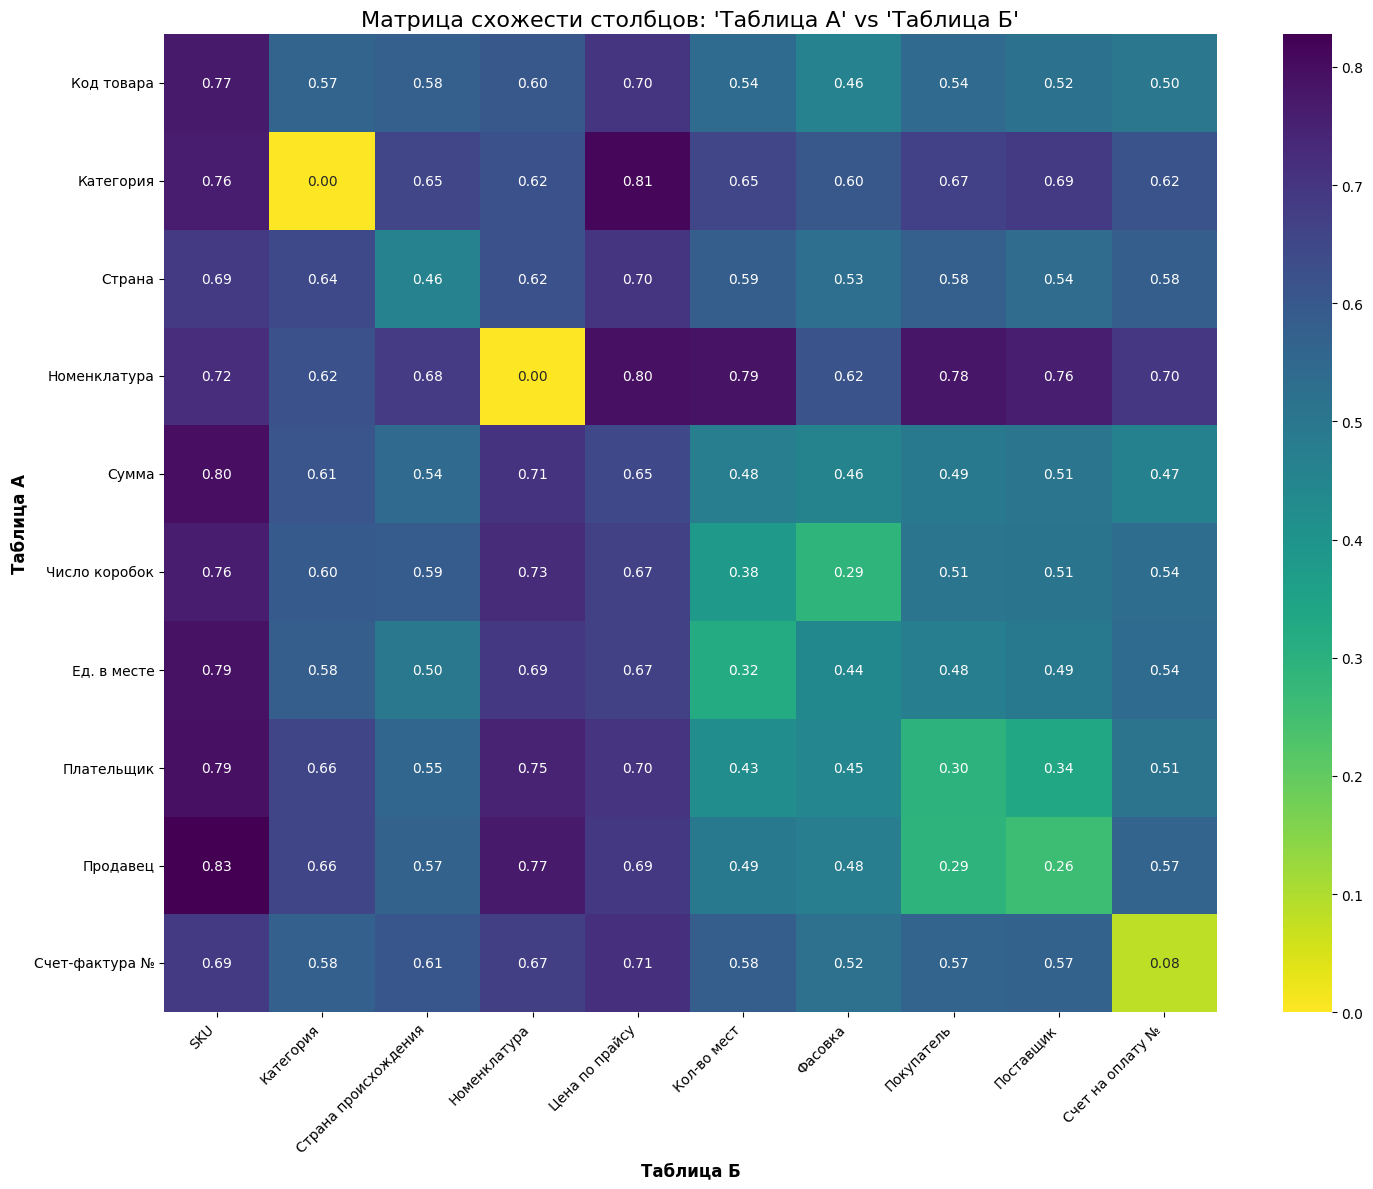

Код товара :  Код товара
Категория :  Категория
Страна :  Страна
Номенклатура :  Номенклатура
Сумма :  Сумма
Число коробок :  Число коробок
Ед. в месте :  Ед. в месте
Плательщик :  Плательщик
Продавец :  Продавец
Счет-фактура № :  Счет-фактура №
---------
SKU :  SKU
Категория :  Категория
Страна происхождения :  Страна происхождения
Номенклатура :  Номенклатура
Цена по прайсу :  Цена по прайсу
Кол-во мест :  Кол-во мест
Фасовка :  Фасовка
Покупатель :  Покупатель
Поставщик :  Поставщик
Счет на оплату № :  Счет на оплату №


In [3]:
host = 'http://100.74.62.22:11434' 
llm_name = 'gemma3:27b'
emb_name = "dengcao/Qwen3-Embedding-0.6B:F16"
#emb_name = "embeddinggemma"
embedder = OllamaEmbedding(host = host, model = emb_name)
llm = OllamaLLM(host = host, model=llm_name)

#Артикул Страна Номенклатура СуммарнаяЦена Количество Покупатель Продавец 

# Таблица А
Serials1 = []
keys1 = ['Код товара','Категория', 'Страна','Номенклатура', 'Сумма', 'Число коробок', 'Ед. в месте']
for key in keys1:
    Serials1.append(EmbSerial(embedder=embedder, llm=llm, name = key, content = dataframe1[key].tolist()))

mets1 = ['Плательщик', 'Продавец', 'Счет-фактура №']
for met in mets1:
    Serials1.append(EmbSerial(embedder=embedder, llm=llm, name = met, content = [metadata1[met]]))

# Таблица Б
Serials2 = []
keys2 = ['SKU', 'Категория', 'Страна происхождения', 'Номенклатура', 'Цена по прайсу', 'Кол-во мест', 'Фасовка']
for key in keys2:
    Serials2.append(EmbSerial(embedder=embedder, llm=llm, name = key, content = dataframe2[key].tolist()))

mets2 = ['Покупатель', 'Поставщик', 'Счет на оплату №']
for met in mets2:
    Serials2.append(EmbSerial(embedder=embedder, llm=llm, name = met, content = [metadata2[met]]))

plot_cross_table_heatmap(
    emb_list_a = Serials1, 
    emb_list_b = Serials2, 
    table_a_name = "Таблица A", 
    table_b_name = "Таблица Б"
)

for Serial in Serials1:
    print(Serial.name, ': ',Serial.description)
print('---------')
for Serial in Serials2:
    print(Serial.name, ': ',Serial.description)

Обработка столбца Код товара...
Столбец обработан!
Обработка столбца Категория...
Столбец обработан!
Обработка столбца Страна...
Столбец обработан!
Обработка столбца Номенклатура...
Столбец обработан!
Обработка столбца Сумма...
Столбец обработан!
Обработка столбца Число коробок...
Столбец обработан!
Обработка столбца Ед. в месте...
Столбец обработан!
Обработка столбца Плательщик...
Столбец обработан!
Обработка столбца Продавец...
Столбец обработан!
Обработка столбца Счет-фактура №...
Столбец обработан!
Обработка столбца SKU...
Столбец обработан!
Обработка столбца Категория...
Столбец обработан!
Обработка столбца Страна происхождения...
Столбец обработан!
Обработка столбца Номенклатура...
Столбец обработан!
Обработка столбца Цена по прайсу...
Столбец обработан!
Обработка столбца Кол-во мест...
Столбец обработан!
Обработка столбца Фасовка...
Столбец обработан!
Обработка столбца Покупатель...
Столбец обработан!
Обработка столбца Поставщик...
Столбец обработан!
Обработка столбца Счет на оп

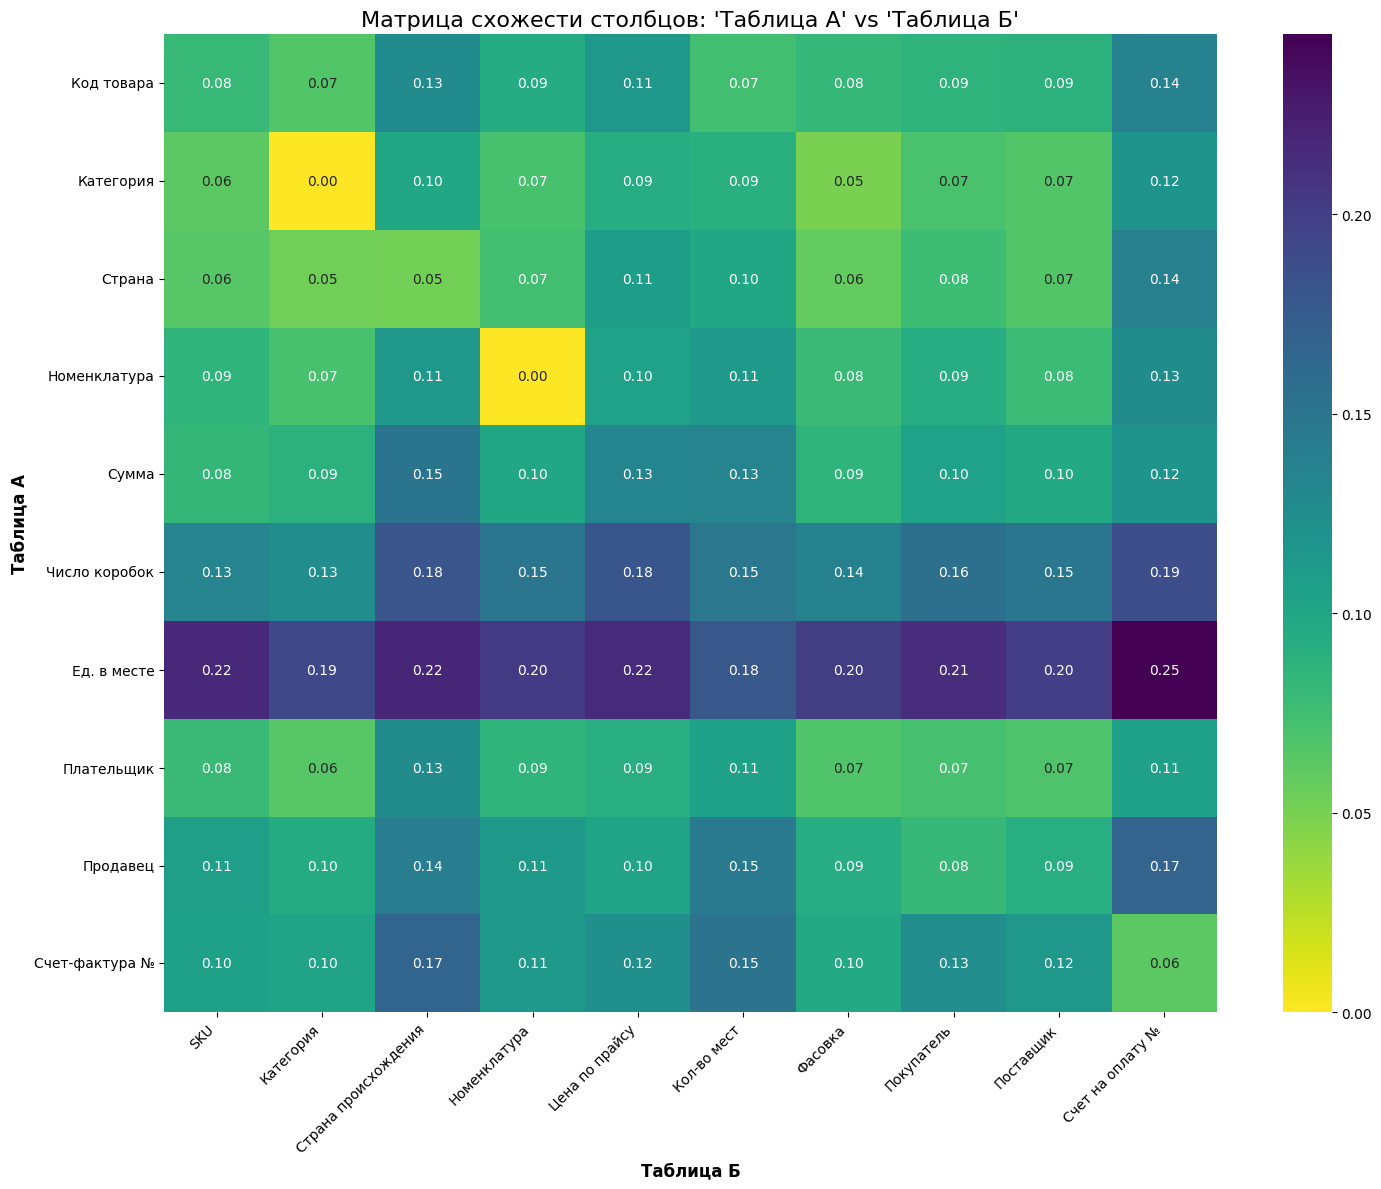

Код товара :  Код товара
Категория :  Категория
Страна :  Страна
Номенклатура :  Номенклатура
Сумма :  Сумма
Число коробок :  Число коробок
Ед. в месте :  Ед. в месте
Плательщик :  Плательщик
Продавец :  Продавец
Счет-фактура № :  Счет-фактура №
---------
SKU :  SKU
Категория :  Категория
Страна происхождения :  Страна происхождения
Номенклатура :  Номенклатура
Цена по прайсу :  Цена по прайсу
Кол-во мест :  Кол-во мест
Фасовка :  Фасовка
Покупатель :  Покупатель
Поставщик :  Поставщик
Счет на оплату № :  Счет на оплату №


In [4]:
host = 'http://100.74.62.22:11434' 
llm_name = 'gemma3:27b'
# emb_name = "dengcao/Qwen3-Embedding-0.6B:F16"
emb_name = "embeddinggemma"
embedder = OllamaEmbedding(host = host, model = emb_name)
llm = OllamaLLM(host = host, model=llm_name)

#Артикул Страна Номенклатура СуммарнаяЦена Количество Покупатель Продавец 

# Таблица А
Serials1 = []
keys1 = ['Код товара','Категория', 'Страна','Номенклатура', 'Сумма', 'Число коробок', 'Ед. в месте']
for key in keys1:
    Serials1.append(EmbSerial(embedder=embedder, llm=llm, name = key, content = dataframe1[key].tolist()))

mets1 = ['Плательщик', 'Продавец', 'Счет-фактура №']
for met in mets1:
    Serials1.append(EmbSerial(embedder=embedder, llm=llm, name = met, content = [metadata1[met]]))

# Таблица Б
Serials2 = []
keys2 = ['SKU', 'Категория', 'Страна происхождения', 'Номенклатура', 'Цена по прайсу', 'Кол-во мест', 'Фасовка']
for key in keys2:
    Serials2.append(EmbSerial(embedder=embedder, llm=llm, name = key, content = dataframe2[key].tolist()))

mets2 = ['Покупатель', 'Поставщик', 'Счет на оплату №']
for met in mets2:
    Serials2.append(EmbSerial(embedder=embedder, llm=llm, name = met, content = [metadata2[met]]))

plot_cross_table_heatmap(
    emb_list_a = Serials1, 
    emb_list_b = Serials2, 
    table_a_name = "Таблица A", 
    table_b_name = "Таблица Б"
)

for Serial in Serials1:
    print(Serial.name, ': ',Serial.description)
print('---------')
for Serial in Serials2:
    print(Serial.name, ': ',Serial.description)

Обработка столбца Код товара...
Столбец обработан!
Обработка столбца Категория...
Столбец обработан!
Обработка столбца Страна...
Столбец обработан!
Обработка столбца Номенклатура...
Столбец обработан!
Обработка столбца Сумма...
Столбец обработан!
Обработка столбца Число коробок...
Столбец обработан!
Обработка столбца Ед. в месте...
Столбец обработан!
Обработка столбца Плательщик...
Столбец обработан!
Обработка столбца Продавец...
Столбец обработан!
Обработка столбца Счет-фактура №...
Столбец обработан!
Обработка столбца SKU...
Столбец обработан!
Обработка столбца Категория...
Столбец обработан!
Обработка столбца Страна происхождения...
Столбец обработан!
Обработка столбца Номенклатура...
Столбец обработан!
Обработка столбца Цена по прайсу...
Столбец обработан!
Обработка столбца Кол-во мест...
Столбец обработан!
Обработка столбца Фасовка...
Столбец обработан!
Обработка столбца Покупатель...
Столбец обработан!
Обработка столбца Поставщик...
Столбец обработан!
Обработка столбца Счет на оп

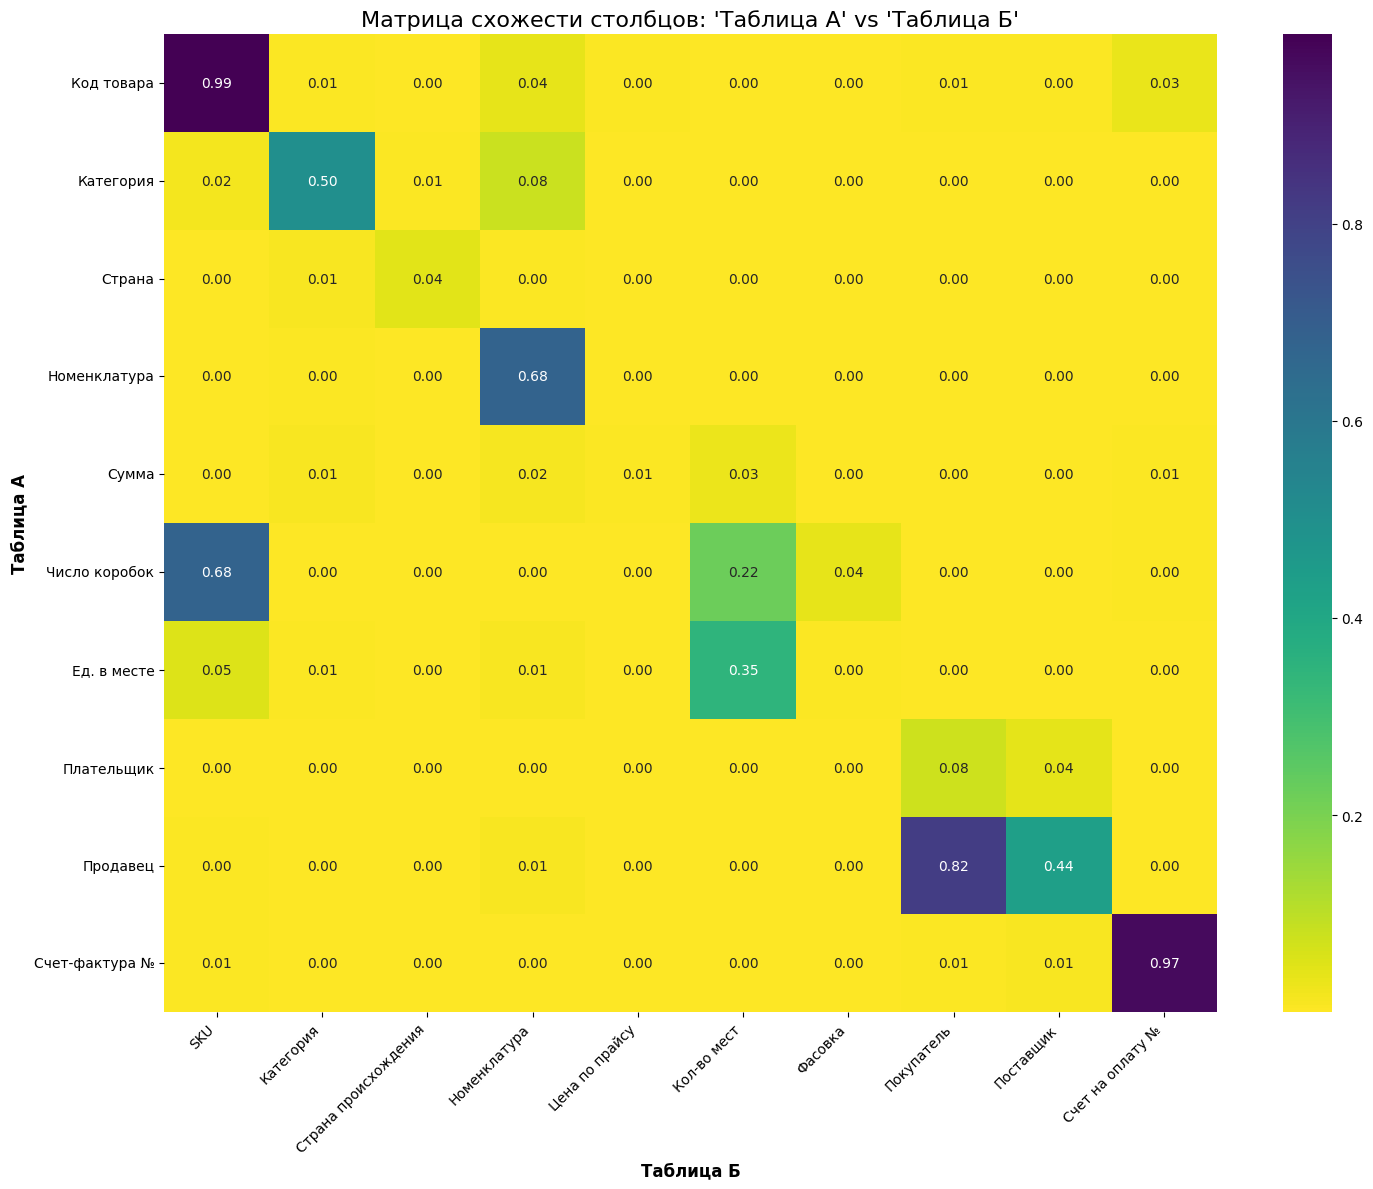

Код товара :  Код товара
Категория :  Категория
Страна :  Страна
Номенклатура :  Номенклатура
Сумма :  Сумма
Число коробок :  Число коробок
Ед. в месте :  Ед. в месте
Плательщик :  Плательщик
Продавец :  Продавец
Счет-фактура № :  Счет-фактура №
---------
SKU :  SKU
Категория :  Категория
Страна происхождения :  Страна происхождения
Номенклатура :  Номенклатура
Цена по прайсу :  Цена по прайсу
Кол-во мест :  Кол-во мест
Фасовка :  Фасовка
Покупатель :  Покупатель
Поставщик :  Поставщик
Счет на оплату № :  Счет на оплату №


In [5]:
host = 'http://100.74.62.22:11434' 
llm_name = 'gpt-oss:20b'
# emb_name = "dengcao/Qwen3-Embedding-0.6B:F16"
emb_name = "embeddinggemma"
embedder = OllamaEmbedding(host = host, model = emb_name)
llm = OllamaLLM(host = host, model=llm_name)

#Артикул Страна Номенклатура СуммарнаяЦена Количество Покупатель Продавец 

# Таблица А
Serials1 = []
keys1 = ['Код товара','Категория', 'Страна','Номенклатура', 'Сумма', 'Число коробок', 'Ед. в месте']
for key in keys1:
    Serials1.append(EmbSerial(embedder=embedder, llm=llm, name = key, content = dataframe1[key].tolist()))

mets1 = ['Плательщик', 'Продавец', 'Счет-фактура №']
for met in mets1:
    Serials1.append(EmbSerial(embedder=embedder, llm=llm, name = met, content = [metadata1[met]]))

# Таблица Б
Serials2 = []
keys2 = ['SKU', 'Категория', 'Страна происхождения', 'Номенклатура', 'Цена по прайсу', 'Кол-во мест', 'Фасовка']
for key in keys2:
    Serials2.append(EmbSerial(embedder=embedder, llm=llm, name = key, content = dataframe2[key].tolist()))

mets2 = ['Покупатель', 'Поставщик', 'Счет на оплату №']
for met in mets2:
    Serials2.append(EmbSerial(embedder=embedder, llm=llm, name = met, content = [metadata2[met]]))

plot_cross_table_heatmap_cross_encoder(
    emb_list_a = Serials1, 
    emb_list_b = Serials2, 
    table_a_name = "Таблица A", 
    table_b_name = "Таблица Б"
)

for Serial in Serials1:
    print(Serial.name, ': ',Serial.description)
print('---------')
for Serial in Serials2:
    print(Serial.name, ': ',Serial.description)

## Qwen3-Embedding-8B:F16

description = f'{self.name}: {self.llm.generate(prompt)}

Обработка столбца Код товара...
Столбец обработан!
Обработка столбца Категория...
Столбец обработан!
Обработка столбца Страна...
Столбец обработан!
Обработка столбца Номенклатура...
Столбец обработан!
Обработка столбца Сумма...
Столбец обработан!
Обработка столбца Число коробок...
Столбец обработан!
Обработка столбца Ед. в месте...
Столбец обработан!
Обработка столбца Плательщик...
Столбец обработан!
Обработка столбца Продавец...
Столбец обработан!
Обработка столбца Счет-фактура №...
Столбец обработан!
Обработка столбца SKU...
Столбец обработан!
Обработка столбца Категория...
Столбец обработан!
Обработка столбца Страна происхождения...
Столбец обработан!
Обработка столбца Номенклатура...
Столбец обработан!
Обработка столбца Цена по прайсу...
Столбец обработан!
Обработка столбца Кол-во мест...
Столбец обработан!
Обработка столбца Фасовка...
Столбец обработан!
Обработка столбца Покупатель...
Столбец обработан!
Обработка столбца Поставщик...
Столбец обработан!
Обработка столбца Счет на оп

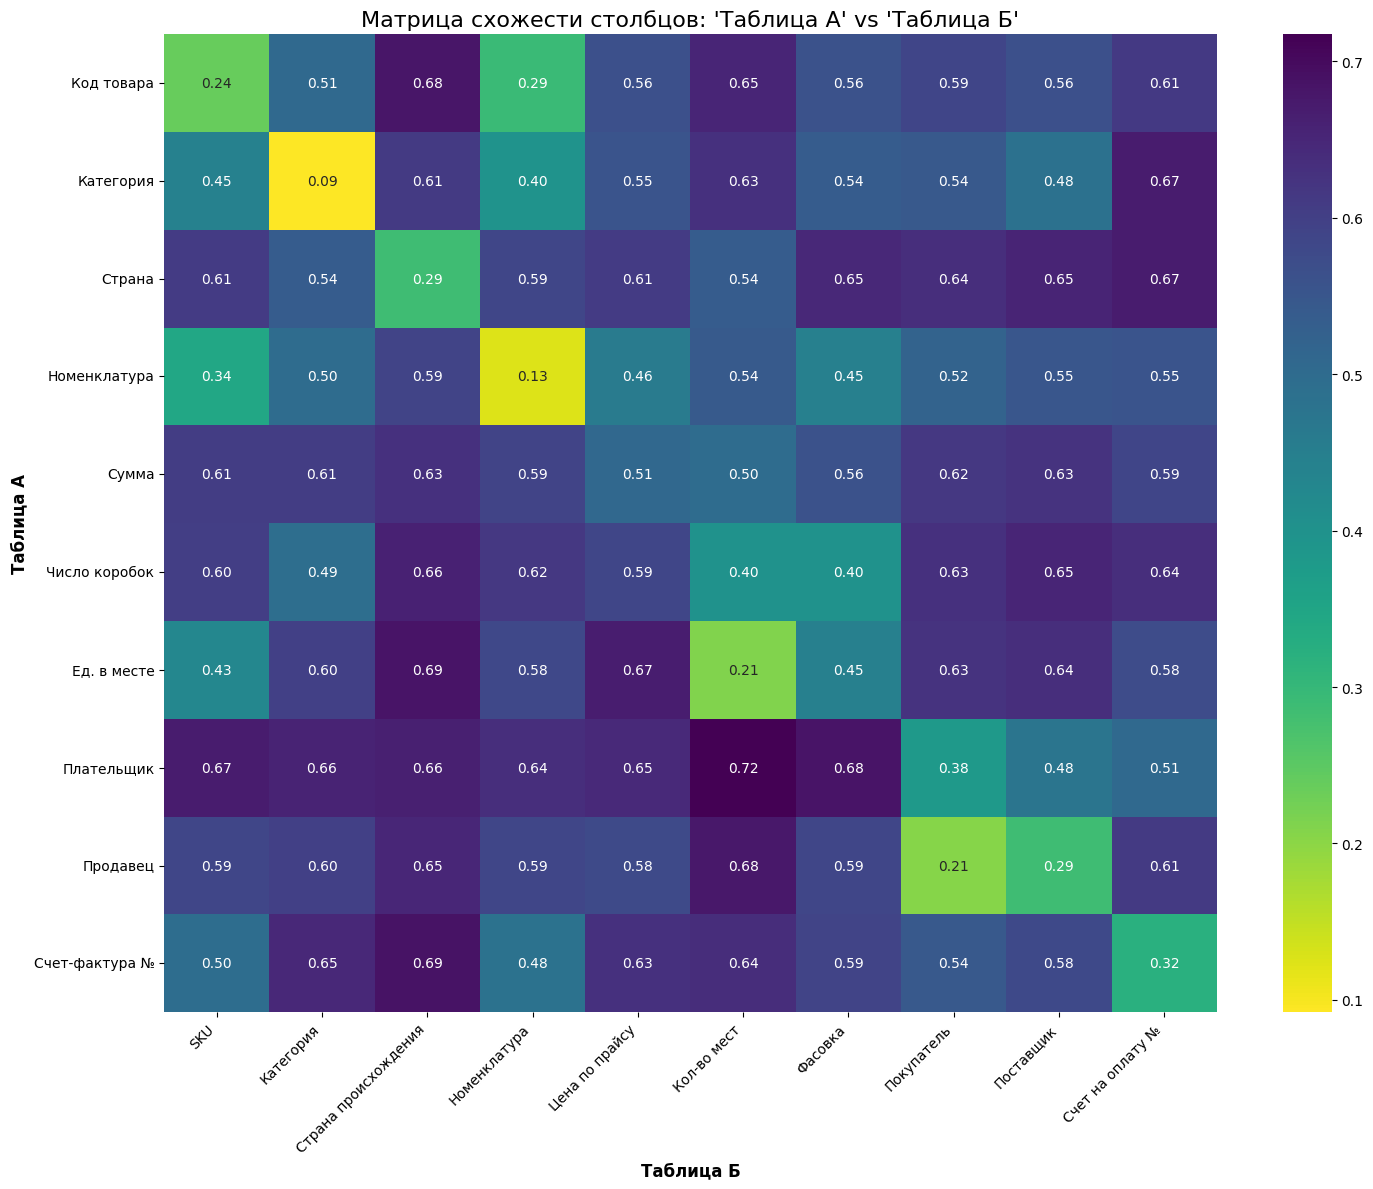

Код товара :  Код товара: Уникальный идентификатор товара. Может использоваться для внутреннего учета и поиска товаров в системе.

Категория :  Категория: Группа, к которой относится товар или услуга.

Страна :  Страна: Страна происхождения или географическая принадлежность объекта/события.

Номенклатура :  Номенклатура: Наименование товара или услуги с указанием характеристик (объем, размер, количество в упаковке и т.д.).

Сумма :  Сумма: Общая денежная величина, результат вычисления или накопленный показатель.

Число коробок :  Число коробок: Количество единиц в группе или партии. Может представлять собой количество физических объектов, записей, или других дискретных элементов.

Ед. в месте :  Ед. в месте: Количество или идентификатор единиц в указанном месте.

Плательщик :  Плательщик: Наименование юридического или физического лица, совершающего платеж или являющегося источником финансовых средств.

Продавец :  Продавец: Наименование организации или физического лица, осуществляющего

In [5]:
host = 'http://100.74.62.22:11434' 
llm_name = 'gemma3:27b'
# emb_name = "dengcao/Qwen3-Embedding-0.6B:F16"
# emb_name = "embeddinggemma"
emb_name = "dengcao/Qwen3-Embedding-8B:F16"
embedder = OllamaEmbedding(host = host, model = emb_name)
llm = OllamaLLM(host = host, model=llm_name)

#Артикул Страна Номенклатура СуммарнаяЦена Количество Покупатель Продавец 

# Таблица А
Serials1 = []
keys1 = ['Код товара','Категория', 'Страна','Номенклатура', 'Сумма', 'Число коробок', 'Ед. в месте']
for key in keys1:
    Serials1.append(EmbSerial(embedder=embedder, llm=llm, name = key, content = dataframe1[key].tolist()))

mets1 = ['Плательщик', 'Продавец', 'Счет-фактура №']
for met in mets1:
    Serials1.append(EmbSerial(embedder=embedder, llm=llm, name = met, content = [metadata1[met]]))

# Таблица Б
Serials2 = []
keys2 = ['SKU', 'Категория', 'Страна происхождения', 'Номенклатура', 'Цена по прайсу', 'Кол-во мест', 'Фасовка']
for key in keys2:
    Serials2.append(EmbSerial(embedder=embedder, llm=llm, name = key, content = dataframe2[key].tolist()))

mets2 = ['Покупатель', 'Поставщик', 'Счет на оплату №']
for met in mets2:
    Serials2.append(EmbSerial(embedder=embedder, llm=llm, name = met, content = [metadata2[met]]))

plot_cross_table_heatmap(
    emb_list_a = Serials1, 
    emb_list_b = Serials2, 
    table_a_name = "Таблица A", 
    table_b_name = "Таблица Б"
)

for Serial in Serials1:
    print(Serial.name, ': ',Serial.description)
print('---------')
for Serial in Serials2:
    print(Serial.name, ': ',Serial.description)

Обработка столбца Код товара...
Столбец обработан!
Обработка столбца Категория...
Столбец обработан!
Обработка столбца Страна...
Столбец обработан!
Обработка столбца Номенклатура...
Столбец обработан!
Обработка столбца Сумма...
Столбец обработан!
Обработка столбца Число коробок...
Столбец обработан!
Обработка столбца Ед. в месте...
Столбец обработан!
Обработка столбца Плательщик...
Столбец обработан!
Обработка столбца Продавец...
Столбец обработан!
Обработка столбца Счет-фактура №...
Столбец обработан!
Обработка столбца SKU...
Столбец обработан!
Обработка столбца Категория...
Столбец обработан!
Обработка столбца Страна происхождения...
Столбец обработан!
Обработка столбца Номенклатура...
Столбец обработан!
Обработка столбца Цена по прайсу...
Столбец обработан!
Обработка столбца Кол-во мест...
Столбец обработан!
Обработка столбца Фасовка...
Столбец обработан!
Обработка столбца Покупатель...
Столбец обработан!
Обработка столбца Поставщик...
Столбец обработан!
Обработка столбца Счет на оп

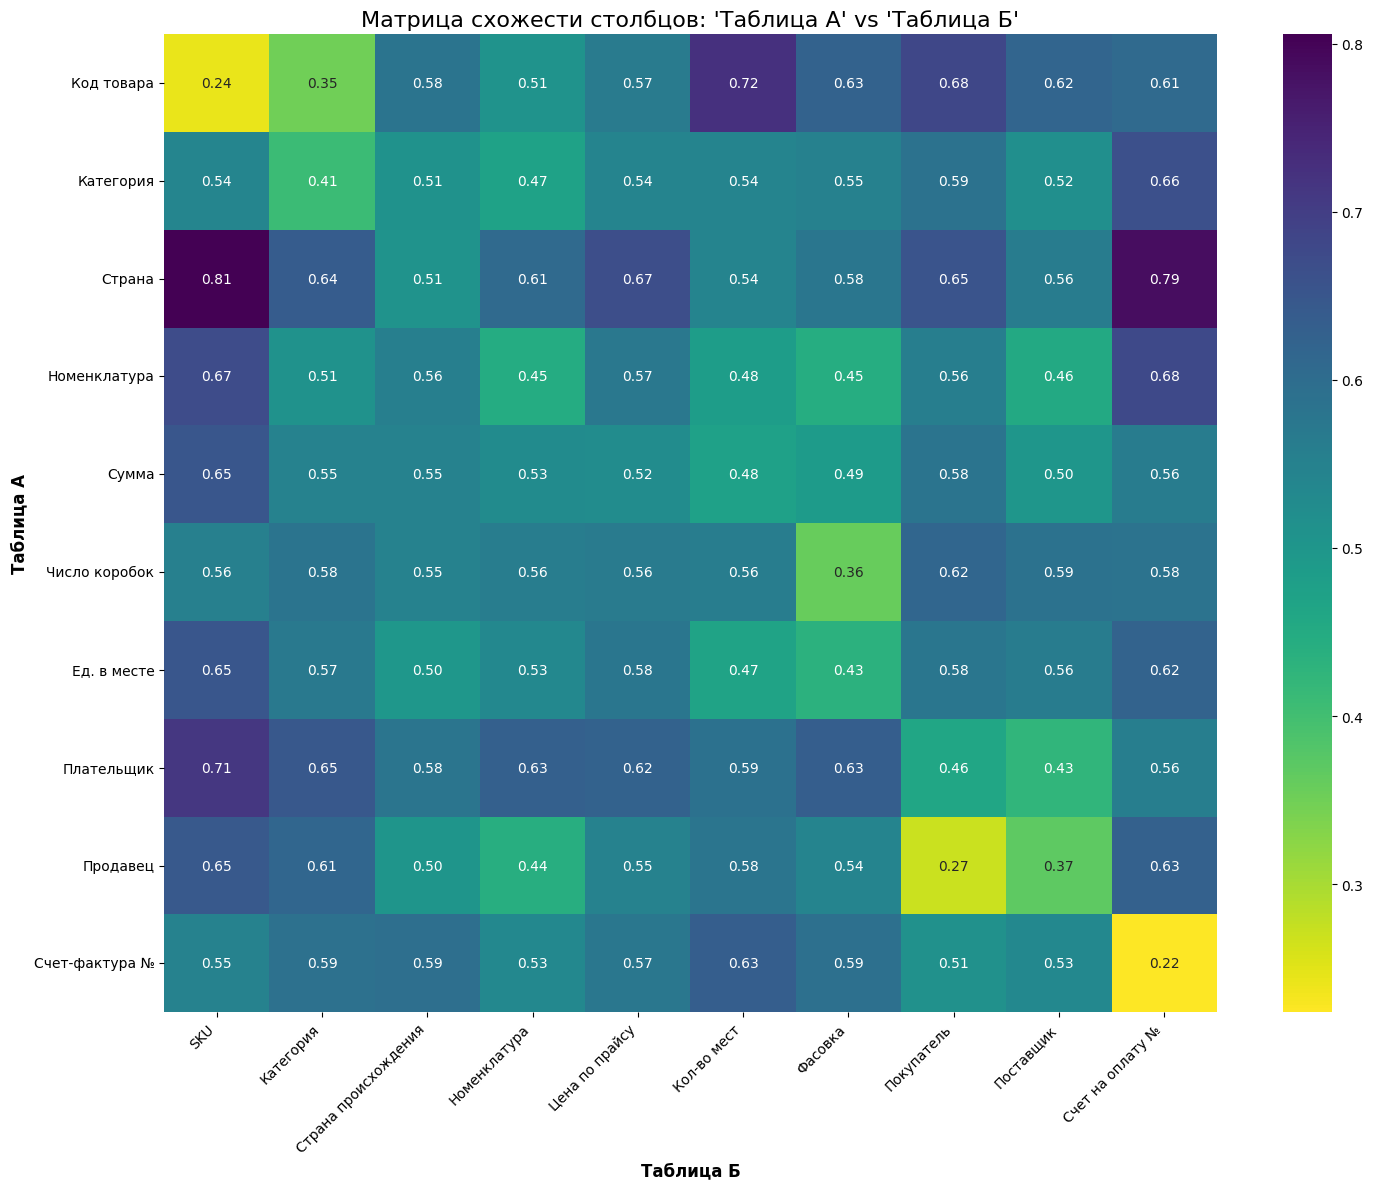

Код товара :  Код товара: Уникальный идентификационный номер товара, представленный числовой строкой различной длины, используемый для учёта, поиска и сканирования продуктов.
Категория :  Категория: Категория товара (тип продукта или группа товаров)
Страна :  Страна: Наименование страны, в которой находится объект или произошло событие
Номенклатура :  Номенклатура: Описание товара (название, вид, размер/объём, цвет, количество)
Сумма :  Сумма: Общая сумма (числовое значение)
Число коробок :  Число коробок: Количество коробок, обозначающее число упаковочных единиц, используемых для хранения, транспортировки или разделения предметов.
Ед. в месте :  Ед. в месте: Число, показывающее количество единиц (объектов, предметов и т.п.), находящихся в конкретном месте.
Плательщик :  Плательщик: Наименование или идентификатор плательщика (организации или физического лица)
Продавец :  Продавец: Наименование продавца (коммерческого субъекта, юридического лица, индивидуального предпринимателя или друг

In [3]:
host = 'http://100.74.62.22:11434' 
llm_name = 'gpt-oss:20b'
# emb_name = "dengcao/Qwen3-Embedding-0.6B:F16"
# emb_name = "embeddinggemma"
emb_name = "dengcao/Qwen3-Embedding-8B:F16"
embedder = OllamaEmbedding(host = host, model = emb_name)
llm = OllamaLLM(host = host, model=llm_name)

#Артикул Страна Номенклатура СуммарнаяЦена Количество Покупатель Продавец 

# Таблица А
Serials1 = []
keys1 = ['Код товара','Категория', 'Страна','Номенклатура', 'Сумма', 'Число коробок', 'Ед. в месте']
for key in keys1:
    Serials1.append(EmbSerial(embedder=embedder, llm=llm, name = key, content = dataframe1[key].tolist()))

mets1 = ['Плательщик', 'Продавец', 'Счет-фактура №']
for met in mets1:
    Serials1.append(EmbSerial(embedder=embedder, llm=llm, name = met, content = [metadata1[met]]))

# Таблица Б
Serials2 = []
keys2 = ['SKU', 'Категория', 'Страна происхождения', 'Номенклатура', 'Цена по прайсу', 'Кол-во мест', 'Фасовка']
for key in keys2:
    Serials2.append(EmbSerial(embedder=embedder, llm=llm, name = key, content = dataframe2[key].tolist()))

mets2 = ['Покупатель', 'Поставщик', 'Счет на оплату №']
for met in mets2:
    Serials2.append(EmbSerial(embedder=embedder, llm=llm, name = met, content = [metadata2[met]]))

plot_cross_table_heatmap(
    emb_list_a = Serials1, 
    emb_list_b = Serials2, 
    table_a_name = "Таблица A", 
    table_b_name = "Таблица Б"
)

for Serial in Serials1:
    print(Serial.name, ': ',Serial.description)
print('---------')
for Serial in Serials2:
    print(Serial.name, ': ',Serial.description)

## description = self.name

Обработка столбца Код товара...
Столбец обработан!
Обработка столбца Категория...
Столбец обработан!
Обработка столбца Страна...
Столбец обработан!
Обработка столбца Номенклатура...
Столбец обработан!
Обработка столбца Сумма...
Столбец обработан!
Обработка столбца Число коробок...
Столбец обработан!
Обработка столбца Ед. в месте...
Столбец обработан!
Обработка столбца Плательщик...
Столбец обработан!
Обработка столбца Продавец...
Столбец обработан!
Обработка столбца Счет-фактура №...
Столбец обработан!
Обработка столбца SKU...
Столбец обработан!
Обработка столбца Категория...
Столбец обработан!
Обработка столбца Страна происхождения...
Столбец обработан!
Обработка столбца Номенклатура...
Столбец обработан!
Обработка столбца Цена по прайсу...
Столбец обработан!
Обработка столбца Кол-во мест...
Столбец обработан!
Обработка столбца Фасовка...
Столбец обработан!
Обработка столбца Покупатель...
Столбец обработан!
Обработка столбца Поставщик...
Столбец обработан!
Обработка столбца Счет на оп

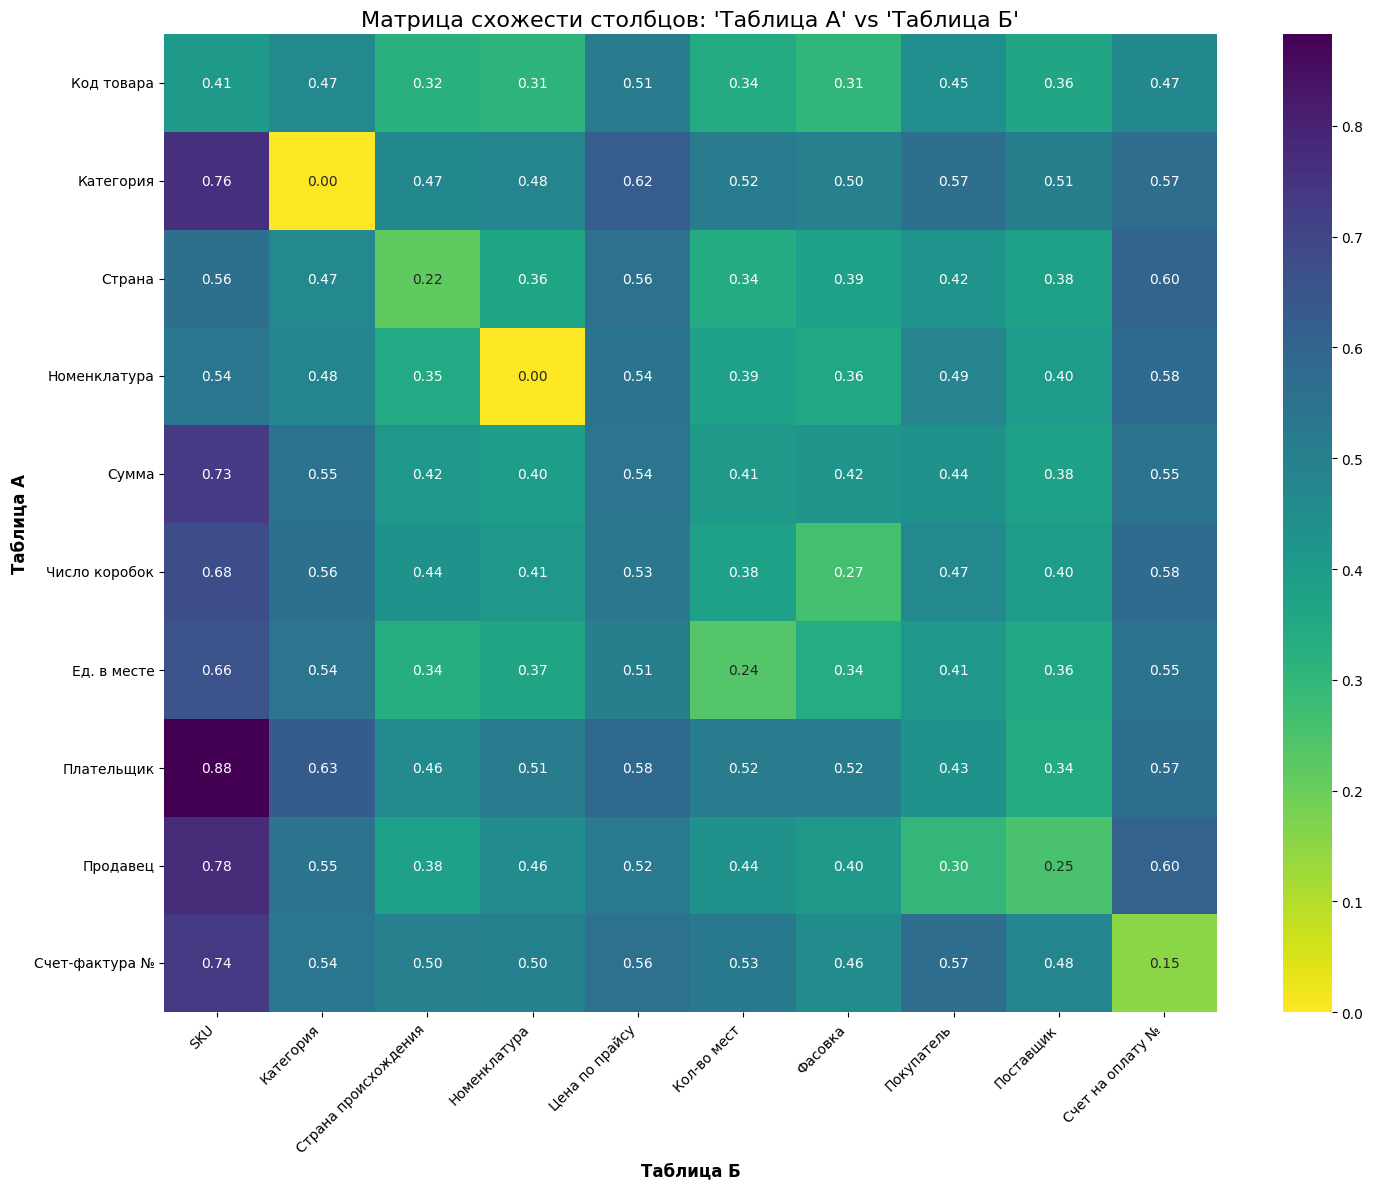

Код товара :  Код товара
Категория :  Категория
Страна :  Страна
Номенклатура :  Номенклатура
Сумма :  Сумма
Число коробок :  Число коробок
Ед. в месте :  Ед. в месте
Плательщик :  Плательщик
Продавец :  Продавец
Счет-фактура № :  Счет-фактура №
---------
SKU :  SKU
Категория :  Категория
Страна происхождения :  Страна происхождения
Номенклатура :  Номенклатура
Цена по прайсу :  Цена по прайсу
Кол-во мест :  Кол-во мест
Фасовка :  Фасовка
Покупатель :  Покупатель
Поставщик :  Поставщик
Счет на оплату № :  Счет на оплату №


In [7]:
host = 'http://100.74.62.22:11434' 
llm_name = 'gpt-oss:20b'
# emb_name = "dengcao/Qwen3-Embedding-0.6B:F16"
# emb_name = "embeddinggemma"
emb_name = "dengcao/Qwen3-Embedding-8B:F16"
embedder = OllamaEmbedding(host = host, model = emb_name)
llm = OllamaLLM(host = host, model=llm_name)

#Артикул Страна Номенклатура СуммарнаяЦена Количество Покупатель Продавец 

# Таблица А
Serials1 = []
keys1 = ['Код товара','Категория', 'Страна','Номенклатура', 'Сумма', 'Число коробок', 'Ед. в месте']
for key in keys1:
    Serials1.append(EmbSerial(embedder=embedder, llm=llm, name = key, content = dataframe1[key].tolist()))

mets1 = ['Плательщик', 'Продавец', 'Счет-фактура №']
for met in mets1:
    Serials1.append(EmbSerial(embedder=embedder, llm=llm, name = met, content = [metadata1[met]]))

# Таблица Б
Serials2 = []
keys2 = ['SKU', 'Категория', 'Страна происхождения', 'Номенклатура', 'Цена по прайсу', 'Кол-во мест', 'Фасовка']
for key in keys2:
    Serials2.append(EmbSerial(embedder=embedder, llm=llm, name = key, content = dataframe2[key].tolist()))

mets2 = ['Покупатель', 'Поставщик', 'Счет на оплату №']
for met in mets2:
    Serials2.append(EmbSerial(embedder=embedder, llm=llm, name = met, content = [metadata2[met]]))

plot_cross_table_heatmap(
    emb_list_a = Serials1, 
    emb_list_b = Serials2, 
    table_a_name = "Таблица A", 
    table_b_name = "Таблица Б"
)

for Serial in Serials1:
    print(Serial.name, ': ',Serial.description)
print('---------')
for Serial in Serials2:
    print(Serial.name, ': ',Serial.description)

## Нормализация векторов перед вычислением косинусного расстояния

In [8]:
metadata1, dataframe1 = parse_excel_invoice(r"c:\Work\table_formatter\generated_invoices\invoice_20250916_115137_968355.xlsx")
metadata2, dataframe2 = parse_excel_invoice(r"C:\Work\table_formatter\generated_invoices\invoice_20250916_115020_659573.xlsx")

host = 'http://100.74.62.22:11434' 
llm_name = 'gpt-oss:20b'
# emb_name = "dengcao/Qwen3-Embedding-0.6B:F16"
# emb_name = "embeddinggemma"
emb_name = "dengcao/Qwen3-Embedding-8B:F16"
embedder = OllamaEmbedding(host = host, model = emb_name)
llm = OllamaLLM(host = host, model=llm_name)

In [9]:
#Артикул Страна Номенклатура СуммарнаяЦена Количество Покупатель Продавец 

# Таблица А
Serials1 = []
keys1 = ['Код товара','Категория', 'Страна','Номенклатура', 'Сумма', 'Число коробок', 'Ед. в месте']
for key in keys1:
    Serials1.append(EmbSerial(embedder=embedder, llm=llm, name = key, content = dataframe1[key].tolist()))

mets1 = ['Плательщик', 'Продавец', 'Счет-фактура №']
for met in mets1:
    Serials1.append(EmbSerial(embedder=embedder, llm=llm, name = met, content = [metadata1[met]]))

# Таблица Б
Serials2 = []
keys2 = ['SKU', 'Категория', 'Страна происхождения', 'Номенклатура', 'Цена по прайсу', 'Кол-во мест', 'Фасовка']
for key in keys2:
    Serials2.append(EmbSerial(embedder=embedder, llm=llm, name = key, content = dataframe2[key].tolist()))

mets2 = ['Покупатель', 'Поставщик', 'Счет на оплату №']
for met in mets2:
    Serials2.append(EmbSerial(embedder=embedder, llm=llm, name = met, content = [metadata2[met]]))

Обработка столбца Код товара...
Столбец обработан!
Обработка столбца Категория...
Столбец обработан!
Обработка столбца Страна...
Столбец обработан!
Обработка столбца Номенклатура...
Столбец обработан!
Обработка столбца Сумма...
Столбец обработан!
Обработка столбца Число коробок...
Столбец обработан!
Обработка столбца Ед. в месте...
Столбец обработан!
Обработка столбца Плательщик...
Столбец обработан!
Обработка столбца Продавец...
Столбец обработан!
Обработка столбца Счет-фактура №...
Столбец обработан!
Обработка столбца SKU...
Столбец обработан!
Обработка столбца Категория...
Столбец обработан!
Обработка столбца Страна происхождения...
Столбец обработан!
Обработка столбца Номенклатура...
Столбец обработан!
Обработка столбца Цена по прайсу...
Столбец обработан!
Обработка столбца Кол-во мест...
Столбец обработан!
Обработка столбца Фасовка...
Столбец обработан!
Обработка столбца Покупатель...
Столбец обработан!
Обработка столбца Поставщик...
Столбец обработан!
Обработка столбца Счет на оп

In [17]:
np.linalg.norm(Serials2[2].embedding)

np.float64(1.0000007724201512)

In [18]:
metadata1, dataframe1 = parse_excel_invoice(r"c:\Work\table_formatter\generated_invoices\invoice_20250916_115137_968355.xlsx")
metadata2, dataframe2 = parse_excel_invoice(r"C:\Work\table_formatter\generated_invoices\invoice_20250916_115020_659573.xlsx")

host = 'http://100.74.62.22:11434' 
llm_name = 'gpt-oss:20b'
# emb_name = "dengcao/Qwen3-Embedding-0.6B:F16"
emb_name = "embeddinggemma"
# emb_name = "dengcao/Qwen3-Embedding-8B:F16"
embedder = OllamaEmbedding(host = host, model = emb_name)
llm = OllamaLLM(host = host, model=llm_name)

#Артикул Страна Номенклатура СуммарнаяЦена Количество Покупатель Продавец 

# Таблица А
Serials1 = []
keys1 = ['Код товара','Категория', 'Страна','Номенклатура', 'Сумма', 'Число коробок', 'Ед. в месте']
for key in keys1:
    Serials1.append(EmbSerial(embedder=embedder, llm=llm, name = key, content = dataframe1[key].tolist()))

mets1 = ['Плательщик', 'Продавец', 'Счет-фактура №']
for met in mets1:
    Serials1.append(EmbSerial(embedder=embedder, llm=llm, name = met, content = [metadata1[met]]))

# Таблица Б
Serials2 = []
keys2 = ['SKU', 'Категория', 'Страна происхождения', 'Номенклатура', 'Цена по прайсу', 'Кол-во мест', 'Фасовка']
for key in keys2:
    Serials2.append(EmbSerial(embedder=embedder, llm=llm, name = key, content = dataframe2[key].tolist()))

mets2 = ['Покупатель', 'Поставщик', 'Счет на оплату №']
for met in mets2:
    Serials2.append(EmbSerial(embedder=embedder, llm=llm, name = met, content = [metadata2[met]]))

Обработка столбца Код товара...
Столбец обработан!
Обработка столбца Категория...
Столбец обработан!
Обработка столбца Страна...
Столбец обработан!
Обработка столбца Номенклатура...
Столбец обработан!
Обработка столбца Сумма...
Столбец обработан!
Обработка столбца Число коробок...
Столбец обработан!
Обработка столбца Ед. в месте...
Столбец обработан!
Обработка столбца Плательщик...
Столбец обработан!
Обработка столбца Продавец...
Столбец обработан!
Обработка столбца Счет-фактура №...
Столбец обработан!
Обработка столбца SKU...
Столбец обработан!
Обработка столбца Категория...
Столбец обработан!
Обработка столбца Страна происхождения...
Столбец обработан!
Обработка столбца Номенклатура...
Столбец обработан!
Обработка столбца Цена по прайсу...
Столбец обработан!
Обработка столбца Кол-во мест...
Столбец обработан!
Обработка столбца Фасовка...
Столбец обработан!
Обработка столбца Покупатель...
Столбец обработан!
Обработка столбца Поставщик...
Столбец обработан!
Обработка столбца Счет на оп

In [21]:
np.linalg.norm(Serials2[6].embedding)

np.float64(0.9999997943666603)

## Венгерский алгоритм

In [ ]:
metadata1, dataframe1 = parse_excel_invoice(r"c:\Work\table_formatter\generated_invoices\invoice_20250916_115137_968355.xlsx")
metadata2, dataframe2 = parse_excel_invoice(r"C:\Work\table_formatter\generated_invoices\invoice_20250916_115020_659573.xlsx")

In [35]:
#Эталон
etalon = {
    'Артикул': [201515515, 20501515, 151525515, 151551515, '1255ABC'],
    'Категория': ['Груши', 'Лимоны', 'Яблоки', 'Яблоки', 'Бананы'],
    'Страна': ['Россия', 'США', 'Япония', 'Китай', 'Эквадор'],
    'Поставщик': ['АО КНИИТМУ', 'КФ МГТУ', 'Альфабанк', 'ВТБ', 'ООО Ромашка'],
    'Покупатель': ['АО КНИИТМУ', 'КФ МГТУ', 'Альфабанк', 'ВТБ', 'ООО Ромашка'],
    'Число коробок': [10, 20, 15, 5, 8],
    'Единиц в коробке': [5, 10, 8, 2, 4],
    'Сумма': [5000, 10000, 7500, 2000, 3200],
}

etalon_embs = []

for name, content in etalon.items():
    etalon_embs.append(EmbSerial(embedder=embedder, llm=llm, name = name, content = content))


Обработка столбца Артикул...
Столбец обработан!
Обработка столбца Категория...
Столбец обработан!
Обработка столбца Страна...
Столбец обработан!
Обработка столбца Поставщик...
Столбец обработан!
Обработка столбца Покупатель...
Столбец обработан!
Обработка столбца Число коробок...
Столбец обработан!
Обработка столбца Единиц в коробке...
Столбец обработан!
Обработка столбца Сумма...
Столбец обработан!


In [45]:
for emb in etalon_embs:
    print(emb.description)

Артикул: Уникальный идентификатор товара, обычно состоящий из цифр и/или букв, используемый для классификации, поиска и учета.
Категория: Категория – тип продукта или предмета, обозначающий его группу (например, фрукт, овощ, товар)
Страна: Наименование страны (государства)
Поставщик: Наименование поставщика (организации, лица, учреждения), предоставляющего товары, услуги или финансовые продукты.
Покупатель: Наименование покупателя (организации, учреждения, предприятия)
Число коробок: Количество коробок (целое число).
Единиц в коробке: Количество единиц, упакованных в одну коробку.
Сумма: Суммарное числовое значение, выражающее общее количество или стоимость.


In [36]:
Classifier = EmbSerialVectorClassifier(etalon_embs)

Классификатор EmbSerial инициализирован для 8 классов.


In [37]:
classified_vectors, outlier_indices = Classifier.classify(input_objects = Serials1, similarity_threshold = 0.5)

In [47]:
for ref_obj, input_obj in classified_vectors.items():
    print(f"  {ref_obj.name}  ->  {input_obj.name} --- {input_obj.description}")
for emb in outlier_indices:
    print(f"Outlier: {emb.description}")

  Артикул  ->  Код товара --- Код товара: Уникальный числовой идентификатор товара, используемый в учёте и распознавании (например, EAN/UPC/штрихкод).
  Категория  ->  Категория --- Категория: Категория товаров, отражающая их тип или назначение (бытовая химия, упаковка, средства для мытья и т.д.).
  Страна  ->  Страна --- Страна: Наименование страны, к которой относится запись.
  Покупатель  ->  Номенклатура --- Номенклатура: Полное название товара с указанием назначения, объёма/размеров, материала и других характеристик.
  Сумма  ->  Сумма --- Сумма: Общее значение суммы в денежном формате, отражающее накопленные денежные ресурсы, доходы, расходы или балансовую величину.
  Число коробок  ->  Число коробок --- Число коробок: Количество коробок, указывающее численное значение для каждой записи.
  Единиц в коробке  ->  Ед. в месте --- Ед. в месте: Количество единиц, находящихся в конкретном месте.
  Поставщик  ->  Продавец --- Продавец: Наименование продавца (организации, индивидуального

In [46]:
classified_vectors2, outlier_indices2 = Classifier.classify(input_objects = Serials2, similarity_threshold = 0.5)
for ref_obj, input_obj in classified_vectors2.items():
    print(f"  {ref_obj.name}  ->  {input_obj.name} --- {input_obj.description}")
for emb in outlier_indices2:
    print(f"Outlier: {emb.description}")

  Артикул  ->  SKU --- SKU: Уникальный код товара, включающий в себя сведения о категории, производителе и порядковый номер.
  Категория  ->  Категория --- Категория: Классификация товаров по типу.
  Страна  ->  Номенклатура --- Номенклатура: Наименование изделия (бренд, тип, модель и основные характеристики)
  Число коробок  ->  Кол-во мест --- Кол-во мест: Количество мест, например, мест для сидения, размещения или посадки.
  Единиц в коробке  ->  Фасовка --- Фасовка: Количество предметов в одной фасовке.
  Покупатель  ->  Покупатель --- Покупатель: Наименование покупателя (организация, юридическое лицо, ИП, физическое лицо).
  Поставщик  ->  Поставщик --- Поставщик: Наименование организации‑поставщика товаров и/или услуг.
  Сумма  ->  Счет на оплату № --- Счет на оплату №: Уникальный идентификатор счета на оплату, включающий дату и порядковый номер.
Outlier: Страна происхождения: Страна происхождения продукта (регион, где он произведён, поставлен или имеет происхождение)
Outlier: Це